# README

sort fig making code so it can run in order

# import

In [123]:
## on nuke, we use env `anaconda3` due to `base` being outdated

import os
import pickle
from tqdm import tqdm
from IPython.display import clear_output

import numpy as np
from numpy import dot
from numpy.linalg import norm

import scipy.io as sio
import scipy.stats as stats
from scipy.stats import ttest_rel
import scikit_posthocs as sp

import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1 # x and y axis thick
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none' # export svg compatible with coreldraw
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [124]:
## plot setting for paper

# cm_to_in = 1/2.54  # centimeters in inches
# scale = 1
# fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

# linewidth=1
# fontsize=8
# plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
# plt.tick_params(direction='out', length=3, width=1)

# plt.xlabel('x', fontsize=9, labelpad=2)
# plt.ylabel('y', fontsize=9, labelpad=1, loc='top')

# ax.spines['left'].set_linewidth(1) # set axis width
# ax.spines['bottom'].set_linewidth(1)

# metadata

In [125]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter/'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [236]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_mat_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info[(data_info.mouse == 1338) | (data_info.mouse == 1339)]

# meta_V1 = data_info[(data_info.paradigm == 'grating') 
#                  & (data_info.area == 'V1') 
#                  & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
#                  & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True)) # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
#                  ].reset_index(drop=True)

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,time,AWS,note
24,1338,210225,V1,200.0,002,NaN,TODO,grating,6s,NaN,NaN,NaN
25,1338,210325,LM,200.0,002,1.0,NaN,grating,6s,NaN,NaN,NaN
39,1338,210616,V1,200.0,002,1.0,NaN,bunny6,6s,NaN,NaN,NaN
42,1338,210805,LM,150.0,002,1.0,NaN,grating,6s,NaN,NaN,NaN
43,1339,210908,LM,150.0,003,NaN,TODO,grating,6s,NaN,NaN,"must manual seg, TC very bad"
44,1339,210922,V1,200.0,002,1.0,NaN,bunny500,6s,NaN,NaN,NaN
45,1339,210922,V1,200.0,003,NaN,NaN,bunny500,6s,NaN,NaN,NaN
46,1339,210922,V1,200.0,004,NaN,NaN,bunny500,6s,NaN,NaN,NaN
47,1339,210930,LI,200.0,002,NaN,True,grating,6s,NaN,NaN,terrible find_ca_latency_ca_window.jpg
48,1339,210930,LI,150.0,003,NaN,True,grating,6s,NaN,NaN,terrible find_ca_latency_ca_window.jpg


In [4]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_mat_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)

meta_V1 = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'V1') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True)) # there are 2 data in V1 that haven't been segmented due to cellpose failing with low quality tiff
                 ].reset_index(drop=True)
meta_single_date = data_info[(data_info.date == 240229)].head(1) # grating_8ori_2isi_multisess, take first sess for metadata
meta_single_date.num = 'multisess' # mark sess number as multisess -> help load df tidy find directory
meta_V1 = pd.concat([meta_V1, meta_single_date], axis=0).reset_index(drop=True) # add this single date to V1
print(meta_V1.area.value_counts())

meta_LM = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LM')
                 & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))].reset_index(drop=True)
print(meta_LM.area.value_counts())

meta_LI = data_info[(data_info.paradigm == 'grating') 
                 & (data_info.area == 'LI') 
                 & (data_info.gcamp == '6s') # avoid mixing in gcamp8f
                 & (data_info.manual_seg != 'TODO') # 2 LI data still need manual segm
                 & (data_info.note.str.contains('bad') != True) # exclude bad data
                 ].reset_index(drop=True)
print(meta_LI.area.value_counts())

meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)

area
V1    7
Name: count, dtype: int64
area
LM    22
Name: count, dtype: int64
area
LI    18
Name: count, dtype: int64


# batch write df_tidy 
(don't rerun unless needed)

In [ ]:
# dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
# dir_xls = os.path.join(dir_data, 'adp_dataset_master.xlsx')
# data_info = pd.read_excel(dir_xls)

# meta = data_info[(data_info.paradigm == 'grating_8ori_2isi_multisess') 
#                  & (data_info.date == 240229)
#                 #  & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True)) # ensure segmentation
#                  ].reset_index(drop=True)
# nset = meta.shape[0]
# meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,time,AWS,note
0,1381,240229,V1,150.0,002,1.0,NaN,grating_8ori_2isi_multisess,6s,NaN,NaN,NaN
1,1381,240229,V1,150.0,003,1.0,NaN,grating_8ori_2isi_multisess,6s,NaN,NaN,NaN


In [ ]:
# meta = pd.concat([meta_V1, meta_LM, meta_LI], axis=0).reset_index(drop=True)
# nset = len(meta)

# for iset in tqdm(range(nset)):
#     print(f'iset={iset}, nset={nset}')


#     ## load data
#     mouse = meta.loc[iset, 'mouse'].astype(str)
#     imouse = 'i' + mouse
#     date = meta.loc[iset, 'date'].astype(str)
#     area = meta.loc[iset, 'area']
#     sess = meta.loc[iset, 'num']
#     print(mouse, date, area, sess)
#     dir_identifier = f'{area}_{imouse}_{date}_{sess}'

#     mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
#     for dirname in os.listdir(mat_inter):
#         if dir_identifier in dirname:
#             dir_data = mat_inter + dirname
#             break

#     stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
#     ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


#     ## construct dfof
#     R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
#     R2_dfof = resp_tg.flatten()
#     dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


#     ## construct cell, trial, resp id
#     ncell = resp_ad.shape[0]
#     ntrial = resp_ad.shape[1]
#     cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
#     cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

#     trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
#     trial_id = np.hstack((trial_id, trial_id))

#     len_df = ncell * ntrial * 2 # 2 for (R1, R2)
#     resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


#     ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
#     trial_stim_orien = [item[0] for item in stim_id['stim_ori']] # print(np.sort(np.unique(trial_stim_orien)))
#     trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
#     for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
#         trial_stim_orien_dict[item] = i
#     trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

#     trial_isi_nframe = [item[0] for item in stim_id['isi_nframe']]
#     trial_adapter_contrast = [item[0] for item in stim_id['adapter_contrast']]

#     trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
#     trial_isi_nframe = trial_isi_nframe[:ntrial]
#     trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

#     ## make stim info col: same as trial_id - tile then hstack
#     stim_id_col = np.tile(trial_stim_orien_int, ncell)
#     isi_col = np.tile(trial_isi_nframe, ncell)
#     ad_con_col = np.tile(trial_adapter_contrast, ncell)

#     stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
#     isi_col = np.hstack((isi_col, isi_col))
#     ad_con_col = np.hstack((ad_con_col, ad_con_col))

#     df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
#                             'isi': isi_col, 'stim1_contrast': ad_con_col, 
#                             'stim2_id': stim_id_col,})
#     df_tidy['area'] = area
#     df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
#     df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
#     df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

#     df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
#     df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


#     ## vis cell filter, well_fit filter, & img driven cell-stim filter
#     df_tidy['filter_cell_vis'] = np.nan
#     df_tidy['filter_cell_vis_pval'] = np.nan # allow continuous filtering on how significant the cell gets visually driven
#     df_tidy['filter_cell_well_fit'] = np.nan
#     df_tidy['filter_cell_stim'] = np.nan

#     with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # changed to strict bonferroni
#     # with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni_strict.pickle'), 'rb') as f: # changed to strict bonferroni
#         filter_file = pickle.load(f)
#     filter_cell_stim = filter_file['img_driven']
#     filter_cell_vis = filter_file['vis_driven']
#     filter_cell_vis_pval = np.min(filter_file['p_ttest'], axis=1) # min pval across all stim

#     # break
        
#     well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
#     well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

#     for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis_pval'] = filter_cell_vis_pval[icell]
#         df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
#         for istim in np.arange(filter_cell_stim.shape[1]):
#             df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
#     # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


#     # ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
#     # fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
#     # ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
#     # ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

#     # ori_pref_runs_sorted = well_fit['ori_pref_runs']
#     # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
#     # # for icell in np.arange(10):
#     # #     plt.plot(ori_pref_runs_sorted[icell, :])

#     # percentile_threshold = 0.9
#     # # if area == 'LI':
#     # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
#     # nrun = ori_pref_runs_sorted.shape[1]
#     # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
#     # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
#     # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


#     # ## goodness of fit (R square) in isi 250 or 750
#     # fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
#     # R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
#     # R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
#     # R_square_250 = R_square[:, 2]
#     # well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
#     # well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


#     # ## write cell property to df_tidy
#     # ncell = df_tidy.cell_id.unique().shape[0]
#     # for icell in np.arange(ncell):
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
#     #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
#     #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
#     break

#     ## save df_tidy as csv
#     # df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_continuous_vis_pval.csv'), index=False)

# # clear_output()

  0%|          | 0/46 [00:00<?, ?it/s]

iset=0, nset=46
1323 200720 V1 003
ncell: 103, nstim: 8, ntrial: 463


  0%|          | 0/46 [00:01<?, ?it/s]


# batch load df tidy

In [5]:
nset = len(meta)
df_tidy = pd.DataFrame()

for iset in tqdm(range(nset)): # 1 min for 7 + 22 + 18 (V1 + LM + LI)

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    sess = meta.loc[iset, 'num']

    dir_identifier = f'{area}_{imouse}_{date}_{sess}'
    if sess == 'multisess':
        dir_identifier = f'{area}_{imouse}_{date}' # multisess data folder has no sess number

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_continuous_vis_pval.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.sess.astype(str) + '_' 
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    
clear_output()
df_tidy['datesess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)

## filter_cell_vis_strict
based on pval

In [126]:
p_sig = 0.05
nstim = 8 # 8 ori

df_tidy['filter_cell_vis_strict'] = df_tidy['filter_cell_vis_pval'] < p_sig / nstim # bonferroni corrected
df_tidy.groupby('cell_id').head(1).groupby('area').filter_cell_vis_strict.value_counts()

area  filter_cell_vis_strict
LI    False                      568
      True                       123
LM    False                     1095
      True                       620
V1    True                       373
      False                      331
Name: count, dtype: int64

# fig1f: trace of single cell in single trials
one noisy cell, one well-fit cell

## find session with good trace

In [7]:
df_tidy['datesess'] = df_tidy.date.astype(str) + '_' + df_tidy.sess.astype(str)
select_datesess = '230302_003    '.strip()
df_now = df_tidy[df_tidy.datesess == select_datesess]
area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + select_datesess
print(area_imouse_date_sess)

dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
try:
    trace = sio.loadmat(dir_sess_trace)
except:
    area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
    dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
    trace = sio.loadmat(dir_sess_trace)
trace_by_trial = trace['trace_by_trial']
ncell = trace_by_trial.shape[0]
ntrial = trace_by_trial.shape[1]
nframe = trace_by_trial.shape[2]
print(f'ncell={ncell}, ntrial={ntrial}, nframe={nframe}')

LM_i1373_230302_003
ncell=139, ntrial=502, nframe=207


## find cells with large adp and R2

In [8]:
R2 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R2'}))

R1 = (df_tidy[(df_tidy.datesess == select_datesess) 
        & (df_tidy.filter_cell_vis == True) & (df_tidy.filter_cell_well_fit == True) 
        & (df_tidy.stim2_id == 0)
        & ( 
           ((df_tidy.isi == 6000) & (df_tidy.resp_id == 'R2')) | 
           (df_tidy.resp_id == 'R1') )
        ]
        .groupby('cell_id').dfof.mean()
        .reset_index().rename(columns={'dfof': 'R1'}))

df_adp = pd.merge(R1, R2, on='cell_id')
df_adp['adp'] = (df_adp.R2 - df_adp.R1) / (df_adp.R1 + 1e-7)
df_adp = df_adp[(df_adp.R1 > 0) & (df_adp.R2 > 0.05)].sort_values('adp', ascending=True).reset_index(drop=True)
df_adp.head(10)

,cell_id,R1,R2,adp
0,230302_003_128,0.719837,0.295017,-0.590161
1,230302_003_81,0.304889,0.135118,-0.556830
2,230302_003_31,0.122934,0.054708,-0.554980
3,230302_003_70,0.143168,0.070537,-0.507312
4,230302_003_108,0.396317,0.208138,-0.474820
5,230302_003_127,0.179214,0.096002,-0.464317
6,230302_003_87,0.120051,0.075011,-0.375177
7,230302_003_58,0.129303,0.086960,-0.327471
8,230302_003_82,0.211765,0.145759,-0.311697
9,230302_003_89,0.212922,0.156721,-0.263952


In [9]:
## select example cells

cell_id = df_adp.head(10).cell_id.values
cell_id = [item.split('_')[-1] for item in cell_id]
cell_id = [int(item) for item in cell_id]
cell_id

[128, 81, 31, 70, 108, 127, 87, 58, 82, 89]

In [10]:
## select example trials (stim2 = 0, isi = 250, resp_id = R2)

trial_id = df_tidy[(df_tidy.datesess == select_datesess) 
            & (df_tidy.stim2_id == 0)
            & (df_tidy.isi == 250) & (df_tidy.resp_id == 'R2')
            ].trial_id.unique()
trial_id

array([  8,  41,  47, 104, 105, 140, 167, 188, 189, 214, 251, 269, 293,
       304, 328, 329, 340, 345, 372, 416, 426, 439, 450, 454, 482, 494],
      dtype=int64)

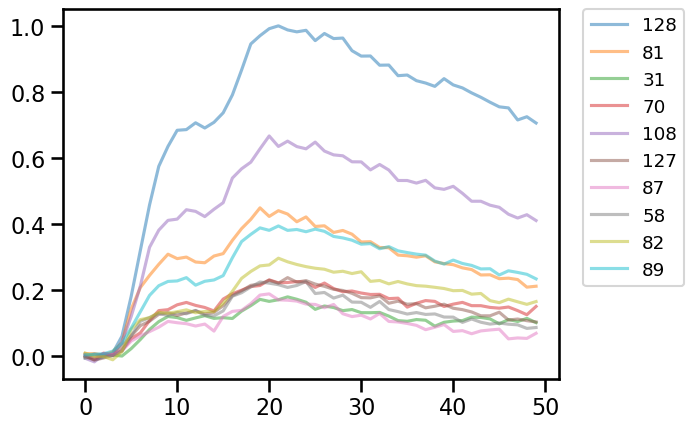

In [11]:
## choose cell by nice avg trace 

for icell in cell_id:
    trace_avg_cell = trace_by_trial[icell, trial_id, :50].mean(axis=0)
    plt.plot(trace_avg_cell, alpha=0.5);
plt.legend(cell_id, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

## single cell single trial trace

In [12]:
tail_frame_start = 190 # trace tail starts from this frame
frame_shift = nframe - tail_frame_start # length of trace tail
nframe_plot = 80 # number of frames to plot

trace_by_trial_tail = trace_by_trial[:, :, tail_frame_start:]
trace_by_trial_tail = trace_by_trial_tail - ((trace_by_trial[:, :, -1] - trace_by_trial[:, :, 0])).reshape(ncell, ntrial, 1)
trace_by_trial_head = trace_by_trial[:, :, :tail_frame_start]
trace_by_trial_reorder = np.concatenate((trace_by_trial_tail, trace_by_trial_head), axis=2)
trace_by_trial_reorder = trace_by_trial_reorder[:, :, :nframe_plot]

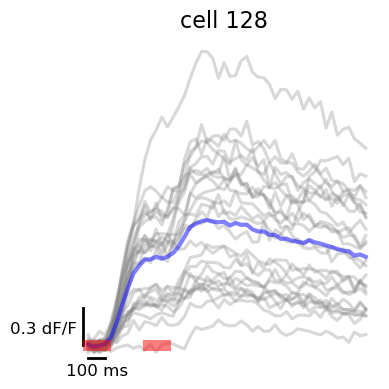

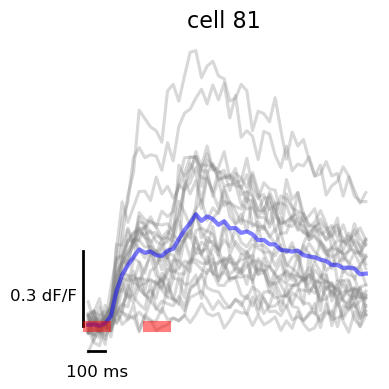

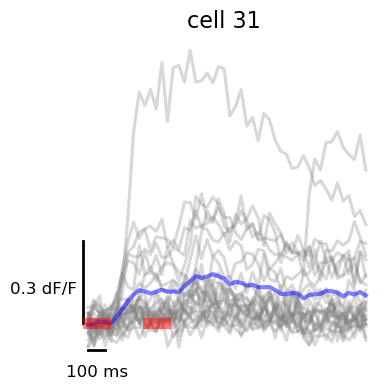

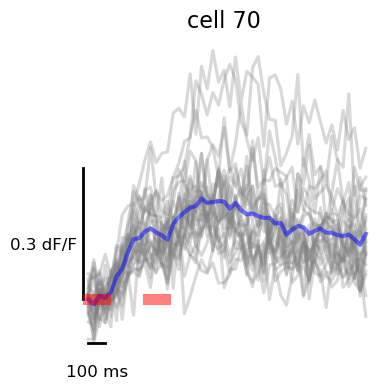

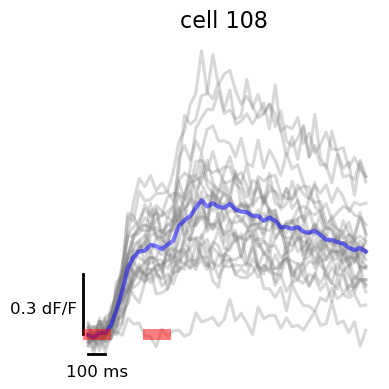

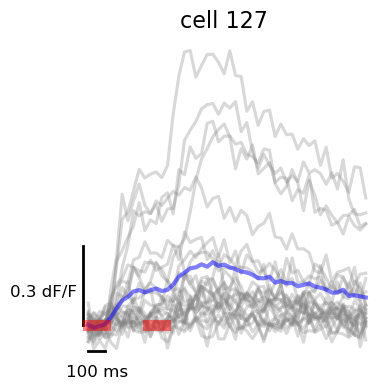

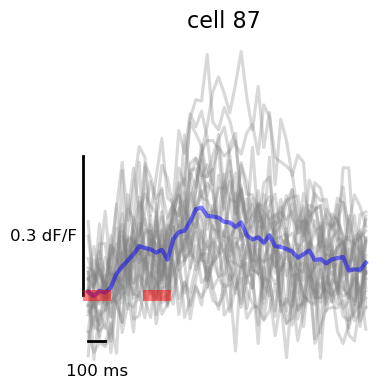

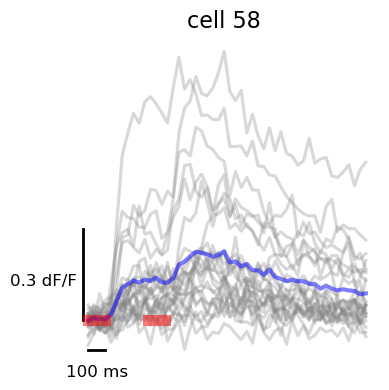

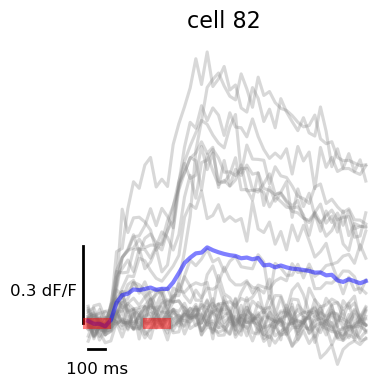

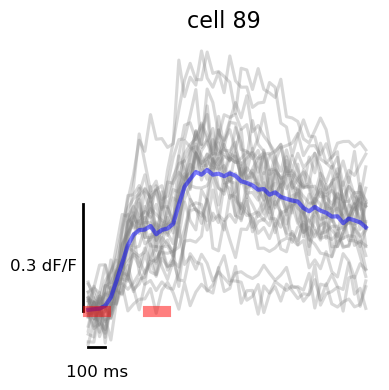

In [13]:
for single_cell_id in cell_id:
    plt.figure(figsize=(4, 4))

    # ylim_upper = 1.3
    ylim_lower = trace_by_trial[single_cell_id, trial_id, :50].min() - 0.01

    for itrial in trial_id:
        trace_trial = trace_by_trial[single_cell_id, itrial, :50]
        plt.plot(trace_trial, alpha=0.3, color='gray');
        # if trace_trial.max() <= ylim_upper:
        #     plt.plot(trace_trial, alpha=0.3, color='gray');
        # else:
        #     print(f'itrial={itrial}, max={round(trace_trial.max(), 2)}')

    trace_agg_cell = trace_by_trial[single_cell_id, trial_id, :50].mean(axis=0)
    # trace_agg_cell = np.median(trace_by_trial[single_cell_id, trial_id, :50], axis=0)
    plt.plot(trace_agg_cell, alpha=0.5, linewidth=3, color='blue');

    # plt.ylim(ylim_lower, ylim_upper);
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);

    ## vertical scale bar at x=-2, y=[0, 0.25]
    plt.plot([-1, -1], [0, 0.3], linewidth=2, color='k');
    ## text on the left of the scale bar
    plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=12);

    ## horizontal scale bar at x=[0, 30], y=0
    plt.plot([0, 3], [-0.1, -0.1], linewidth=2, color='k');
    ## text on the bottom of the scale bar
    plt.text(1.5, -0.15, '100 ms', ha='center', va='top', fontsize=12);

    frame_shift = 0
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100

    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=8, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=8, color='r', alpha=0.5);

    plt.title(f'cell {single_cell_id}', fontsize=16);
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    # plt.savefig(dir_fig + r'fig1_example_single_vis_cell_single_trial_trace.pdf')

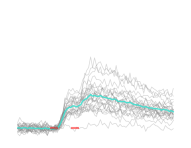

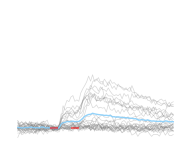

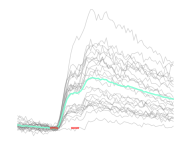

In [14]:
cell_id_example = [108, 82, 128]
ylim_lower = trace_by_trial_reorder[cell_id_example, :, :]
ylim_lower = ylim_lower[:, trial_id, :].min() - 0.01
ylim_upper = trace_by_trial_reorder[cell_id_example, :, :]
ylim_upper = ylim_upper[:, trial_id, :].max() + 0.01
color_arr = ['turquoise', 'lightskyblue', 'aquamarine']

for icell, single_cell_id in enumerate(cell_id_example):
    cm_to_in = 1/2.54  # centimeters in inches
    scale = 1.5
    fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

    for itrial in trial_id:
        trace_trial = trace_by_trial_reorder[single_cell_id, itrial, :]
        plt.plot(trace_trial, alpha=0.3, linewidth=0.5, color='gray');

    trace_agg_cell = trace_by_trial_reorder[single_cell_id, trial_id, :].mean(axis=0)
    plt.plot(trace_agg_cell, alpha=0.9, linewidth=1, color=color_arr[icell]);

    # ## stim R1 and R2 arrow, only for the first cell
    # if icell == 0:
    #     base1_id = 0 + frame_shift
    #     stim1_id = 13 + frame_shift
    #     base2_id = 15 + frame_shift
    #     # plt.axvline(base2_id, linestyle='--', color='dimgray', linewidth=2)
    #     stim2_id = 22 + frame_shift
    #     plt.annotate(text='', xy=(stim1_id, trace_agg_cell[base1_id]), xytext=(stim1_id, trace_agg_cell[stim1_id]), \
    #                 arrowprops=dict(arrowstyle='-', linewidth=1, color='dimgray'));
    #     plt.annotate(text='', xy=(stim2_id, trace_agg_cell[base2_id]), xytext=(stim2_id, trace_agg_cell[stim2_id]), \
    #                 arrowprops=dict(arrowstyle='-', linewidth=1, color='dimgray'));
    
    #     ## add text for arrow
    #     buffer_space = 5.5
    #     adjust_down_space = 0.08
    #     plt.text(stim1_id + buffer_space, (trace_agg_cell[stim1_id] + trace_agg_cell[base1_id]) / 2 - adjust_down_space, \
    #             'R1', ha='center', va='bottom', fontsize=8, color='dimgray')
    #     plt.text(stim2_id + buffer_space, (trace_agg_cell[stim2_id] + trace_agg_cell[base2_id]) / 2 - adjust_down_space, \
    #             'R2', ha='center', va='bottom', fontsize=8, color='dimgray')

    
    ## stim onset and offset
    frame_shift = nframe - tail_frame_start # length of trace tail
    frame_rate = 30
    stim1_sec = 0.100
    isi_sec = 0.250
    stim2_sec = 0.100
    stim1_time = np.arange(0 + frame_shift, 
                        frame_rate * stim1_sec + frame_shift, 
                        0.01)
    stim2_time = np.arange(frame_rate * (stim1_sec + isi_sec) + frame_shift, 
                        frame_rate * (stim1_sec + isi_sec + stim2_sec) + frame_shift, 
                        0.01)
    y = np.ones(stim1_time.shape) * 0
    plt.plot(stim1_time, y, linewidth=1.5, color='r', alpha=0.5) # plot stim onset time
    plt.plot(stim2_time, y, linewidth=1.5, color='r', alpha=0.5);


    # ## vertical scale bar at x=-2, y=[0, 0.25]
    # plt.plot([-1, -1], [0, 0.3], linewidth=1, color='k');
    # ## text on the left of the scale bar
    # plt.text(-2, 0.125, '0.3 dF/F', ha='right', va='center', fontsize=8);

    # ## horizontal scale bar at x=[0, 30], y=0
    # plt.plot([0, frame_rate * 0.5], [-0.1, -0.1], linewidth=1, color='k');
    # ## text on the bottom of the scale bar
    # plt.text(7, -0.15, '0.5 s', ha='center', va='top', fontsize=8);


    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.xticks([])
    plt.yticks([]);
    plt.ylim(ylim_lower, ylim_upper); # sharey=True
    plt.tight_layout();

    dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
    # fig.savefig(dir_fig + 
    #             f'fig1_example_single_vis_cell_single_trial_trace_{single_cell_id}_{area_imouse_date_sess}_figsize_noscalebar_frameshift.svg', 
    #             bbox_inches='tight', transparent=True)
    # break

# find wellmax & tuning bias
skip to section end to read_csv

## filter cell well-max 
(no rerun, runtime 4 min)

In [78]:
# ## construct tuning_vec column
# max_ori_bootstrap = np.array([])
# nboot = 50
# for iboot in tqdm(range(nboot)):
#     max_ori = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
#                 [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
#                 .groupby(['cell_id', 'isi', 'stim2_id'])
#                 .sample(frac=.7, random_state=iboot) # sample x trials per group. min rep = 48
#                 .groupby(['cell_id', 'isi', 'stim2_id'])
#                 .agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
#                 .groupby(['cell_id', 'isi']).apply(lambda x: np.argmax(x)) # get ori with max resp
#                 .reset_index() # NOTE: due to prev groupby, cell_id and isi are in order
#                 .rename(columns={0: 'max_ori'}).max_ori.values
#                 )
#     max_ori_bootstrap = np.append(max_ori_bootstrap, max_ori)
# max_ori_bootstrap = max_ori_bootstrap.reshape(nboot, -1) # reshape max_ori_bootstrap to: nboot x (ncell x nisi)

# ## sort max_ori_bootstrap in each col (across boots)
# max_ori_bootstrap = np.sort(max_ori_bootstrap, axis=0)
# # sns.heatmap(max_ori_bootstrap[:, 10:30], cmap='viridis', cbar=True, annot=True);

# ## count the most freq value in each col (across boots)
# max_ori_mode_freq = stats.mode(max_ori_bootstrap, axis=0)[1] # count of mode (freq of most freq max_ori)
# filter_cell_well_max = (max_ori_mode_freq >= nboot * 0.7) # NOTE: strictness of well-max can be adjusted here

# ## merge filter_cell_well_max with df
# df_well_max = (df_tidy[df_tidy.resp_id == 'R2'][['cell_id', 'isi']]
#                 .groupby(['cell_id', 'isi'])
#                 .first() # get first trial per cell, isi
#                 .reset_index() # due to prev groupby, cell_id and isi are in the same order as max_ori
#                 )
# df_well_max['filter_cell_well_max'] = filter_cell_well_max

# df_tidy = df_tidy.merge(df_well_max, 
#       on=['cell_id', 'isi'], how='left') # take filter_cell_well_max from df_well_max, for each cell and isi

100%|██████████| 50/50 [00:08<00:00,  5.88it/s]


## tuning pref & tuning bias
(no rerun)
crude preference: take max-resp orientation as the preferred orien

In [80]:
# pref_ori_noad = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 6000)]
#                 .groupby(['cell_id', 'stim2_id'])
#                 [['dfof']].sum().reset_index()
#                 .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
#                 ['dfof'].apply(list).to_frame()
#                 .dfof.apply(lambda x: np.argmax(x)).to_frame()
#                 .rename(columns={'dfof': 'pref_ori_noad'})
#                 )

# pref_ori_ad_250 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 250)]
#                 .groupby(['cell_id', 'stim2_id'])
#                 [['dfof']].sum().reset_index()
#                 .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
#                 ['dfof'].apply(list).to_frame()
#                 .dfof.apply(lambda x: np.argmax(x)).to_frame()
#                 .rename(columns={'dfof': 'pref_ori_ad_250'})
#                 )

# # pref_ori_ad_750 = (df_tidy[(df_tidy.resp_id == 'R2') & (df_tidy.isi == 750)]
# #                 .groupby(['cell_id', 'stim2_id'])
# #                 [['dfof']].sum().reset_index()
# #                 .groupby('cell_id') # NOTE: stim2_id is sorted due to prev groupby
# #                 ['dfof'].apply(list).to_frame()
# #                 .dfof.apply(lambda x: np.argmax(x)).to_frame()
# #                 .rename(columns={'dfof': 'pref_ori_ad_750'})
# #                 )

# df_tidy = (df_tidy.merge(pref_ori_noad, on='cell_id')
#             .merge(pref_ori_ad_250, on='cell_id')
#             # .merge(pref_ori_ad_750, on='cell_id') # dont merge pref_ori_ad_750, to accommodate for multisess 8 ori 2 isi data
#             )

In [82]:
# def bin_ori(x):
#     # bin pref ori to 0, 45, 90
#     if x < 30:
#         return 0
#     elif x <= 60:
#         return 45
#     else:
#         return 90

# def distace_from_adapter(x):
#     # adapter is always 0 deg
#     x = 22.5*x # convert from stim id int to degree
#     if x > 90:
#         x = 180 - x
#     return x


# df_tidy['pref_unadapted_distance'] = df_tidy['pref_ori_noad'].apply(lambda x: distace_from_adapter(x)) # unadapted pref ori, distance from adapter
# df_tidy['pref_unadapted_distance_bin'] = df_tidy['pref_unadapted_distance'].apply(lambda x: bin_ori(x)) # bin the distance to 0, 45, 90

# df_tidy.loc[(df_tidy.isi == 250), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_250'].apply(lambda x: distace_from_adapter(x)) # isi 250 adapted pref ori, distance from adapter # TODO: refactor pref_ori_ad_250 similarly, so it's only one column of pref_ori_ad, but can filter by isi
# # df_tidy.loc[(df_tidy.isi == 750), 'pref_adapted_distance'] = df_tidy['pref_ori_ad_750'].apply(lambda x: distace_from_adapter(x)) # isi 750 adapted pref ori, distance from adapter
# df_tidy['tuning_bias'] = df_tidy['pref_adapted_distance'] - df_tidy['pref_unadapted_distance'] # distance from adapter, adapted - unadapted. if tuning repelled from adapter, this is positive; attracted, negative

# df_tidy.head()

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,sess,datesess,filter_cell_vis_strict,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias
0,0.009184,240229_multisess_0,1,R1,250,1,7,V1,0,False,...,multisess,240229_multisess,True,True,7,5,22.5,0,67.5,45.0
1,-0.011983,240229_multisess_0,2,R1,250,1,6,V1,0,False,...,multisess,240229_multisess,True,True,7,5,22.5,0,67.5,45.0
2,0.195770,240229_multisess_0,3,R1,250,1,3,V1,0,False,...,multisess,240229_multisess,True,True,7,5,22.5,0,67.5,45.0
3,0.232615,240229_multisess_0,5,R1,250,1,6,V1,0,False,...,multisess,240229_multisess,True,True,7,5,22.5,0,67.5,45.0
4,0.061147,240229_multisess_0,6,R1,250,1,3,V1,0,False,...,multisess,240229_multisess,True,True,7,5,22.5,0,67.5,45.0


## tuning curve
no rerun, runtime 30+ min

In [83]:
# df_tuning = df_tidy.copy()
# df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
#                     & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
#                     ]
# df_tuning['tuning_noad'] = np.pi
# df_tuning['tuning_250'] = np.pi

# for icell in tqdm(df_tuning.cell_id.unique()):
#     ## tuning curve when isi = 6000, no adapter
#     tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values # groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
#     df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
#     ## tuning curve when isi = 250
#     tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).dfof.agg(np.nanmean).values
#     df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

# df_tuning.head(5) # NOTE: where isi=6000, pref_adapted_distance and tuning_bias are NaN

100%|██████████| 121/121 [00:12<00:00,  9.85it/s]


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_vis_strict,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_noad,tuning_250
0,0.009184,240229_multisess_0,1,R1,250,1,7,V1,0,False,...,True,True,7,5,22.5,0,67.5,45.0,"[0.023007394123808266, 0.018652949731595155, 0...","[0.009544861272725904, 0.01935180743242945, 0...."
1,-0.011983,240229_multisess_0,2,R1,250,1,6,V1,0,False,...,True,True,7,5,22.5,0,67.5,45.0,"[0.023007394123808266, 0.018652949731595155, 0...","[0.009544861272725904, 0.01935180743242945, 0...."
2,0.195770,240229_multisess_0,3,R1,250,1,3,V1,0,False,...,True,True,7,5,22.5,0,67.5,45.0,"[0.023007394123808266, 0.018652949731595155, 0...","[0.009544861272725904, 0.01935180743242945, 0...."
3,0.232615,240229_multisess_0,5,R1,250,1,6,V1,0,False,...,True,True,7,5,22.5,0,67.5,45.0,"[0.023007394123808266, 0.018652949731595155, 0...","[0.009544861272725904, 0.01935180743242945, 0...."
4,0.061147,240229_multisess_0,6,R1,250,1,3,V1,0,False,...,True,True,7,5,22.5,0,67.5,45.0,"[0.023007394123808266, 0.018652949731595155, 0...","[0.009544861272725904, 0.01935180743242945, 0...."


# load df_tuning 

In [152]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_visp_addmultisess.csv'
# df_tuning.to_csv(os.path.join(dir_data, csv_filename), index=False) # 2 min
df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))

clear_output() # clear dtypewarning
df_tuning.head(2)

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,...,filter_cell_well_max,pref_ori_noad,pref_ori_ad_250,pref_ori_ad_750,pref_unadapted_distance,pref_unadapted_distance_bin,pref_adapted_distance,tuning_bias,tuning_noad,tuning_250
0,0.088726,200720_003_0,1,R1,250,1,2,V1,0,True,...,False,4,3,3.0,90.0,90,67.5,-22.5,[ 0.02015273 -0.00139456 0.02329481 0.085983...,[ 0.016362 0.01027813 0.05681277 0.073368...
1,-0.010485,200720_003_0,2,R1,250,1,2,V1,0,True,...,False,4,3,3.0,90.0,90,67.5,-22.5,[ 0.02015273 -0.00139456 0.02329481 0.085983...,[ 0.016362 0.01027813 0.05681277 0.073368...


In [153]:
## fix tuning_noad column in saved csv: convert from str (fake list) to list of float
if df_tuning['tuning_noad'].values[0].__class__ == str:
    df_tuning['tuning_noad'] = df_tuning['tuning_noad'].apply(lambda x: x.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' '))
    df_tuning['tuning_noad'] = df_tuning['tuning_noad'].apply(lambda x: [float(i) for i in x if i != ''])
    df_tuning['tuning_250'] = df_tuning['tuning_250'].apply(lambda x: x.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' '))
    df_tuning['tuning_250'] = df_tuning['tuning_250'].apply(lambda x: [float(i) for i in x if i != ''])

# fig2b: R1 ori=pref across area

p_kruskal=1.09e-04
p_mannwhit_V1LM=2.21e-02
p_mannwhit_LMLI=2.76e-03
p_mannwhit_V1LI=3.26e-05


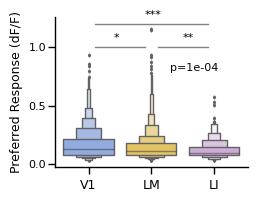

In [128]:
def R1_pref_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == df_filter.pref_ori_noad) & (df_filter.resp_id == 'R2') & (df_filter.isi == 6000)].groupby(['area', 'cell_id']).dfof.mean().values # avg over rep trials, where stim2_id of this trial == pref_ori_noad of this cell, isi == 6000 (no adapter), get R2

    gb_R1 = gb_R1[(np.abs(gb_R1 >= 0.033)) 
                ] # NOTE: use the same cell filter as func adp_in_area
    return gb_R1


df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]
gb_R1_pref_V1 = R1_pref_in_area(df_filter[df_filter.area == 'V1'])
gb_R1_pref_LM = R1_pref_in_area(df_filter[df_filter.area == 'LM'])
gb_R1_pref_LI = R1_pref_in_area(df_filter[df_filter.area == 'LI'])


cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_R1_pref_V1, gb_R1_pref_LM, gb_R1_pref_LI], 
                palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

_, p_kruskal = stats.kruskal(gb_R1_pref_V1, gb_R1_pref_LM, gb_R1_pref_LI)
plt.text(1.3, 0.8, 'p={:.0e}'.format(p_kruskal), fontsize=8)
print('p_kruskal={:.2e}'.format(p_kruskal))

## add significance stars for posthoc mann whitney u test (Wilcoxon rank-sum test)
_, p_mannwhit_V1LM = stats.mannwhitneyu(gb_R1_pref_V1, gb_R1_pref_LM)
_, p_mannwhit_LMLI = stats.mannwhitneyu(gb_R1_pref_LM, gb_R1_pref_LI)
_, p_mannwhit_V1LI = stats.mannwhitneyu(gb_R1_pref_V1, gb_R1_pref_LI)
p_mannwhit = [p_mannwhit_V1LM, p_mannwhit_LMLI, p_mannwhit_V1LI]
print('p_mannwhit_V1LM={:.2e}'.format(p_mannwhit_V1LM))
print('p_mannwhit_LMLI={:.2e}'.format(p_mannwhit_LMLI))
print('p_mannwhit_V1LI={:.2e}'.format(p_mannwhit_V1LI))

sig_star_str = []
for i, pval in enumerate(p_mannwhit):
    if pval < 0.001:
        sig_star_str.append('***')
    elif pval < 0.01:
        sig_star_str.append('**')
    elif pval < 0.05:
        sig_star_str.append('*')
    else:
        sig_star_str.append('n.s.')

## first, draw horizontal lines to connect pairs of groups
sig_bar_y = 1
sig_bar_shorten = 0.1
plt.plot([0+sig_bar_shorten, 1-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
plt.plot([1+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
sig_bar_y += 0.2
plt.plot([0+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)

## then, draw significance stars
sig_star_y_base = 1.05
sig_star_y = [sig_star_y_base, sig_star_y_base, sig_star_y_base+0.2]
sig_star_x = [0.4, 1.5, 0.9] # V1-LM, LM-LI, V1-LI
for i, sig_star in enumerate(sig_star_str):
    plt.text(sig_star_x[i], sig_star_y[i], sig_star, fontsize=8)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=9);
plt.ylabel('Preferred Response (dF/F)', fontsize=9);
plt.yticks(fontsize=8);

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();
# plt.savefig(os.path.join(dir_fig, 'fig2_R1_pref_by_area_addV1multisess.svg'))

In [129]:
## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
p_dunn_V1LM = sp.posthoc_dunn([gb_R1_pref_V1, gb_R1_pref_LM, ], p_adjust='bonferroni')
p_dunn_V1LI = sp.posthoc_dunn([gb_R1_pref_V1, gb_R1_pref_LI], p_adjust='bonferroni')
p_dunn_LMLI = sp.posthoc_dunn([gb_R1_pref_LM, gb_R1_pref_LI], p_adjust='bonferroni')
p_dunn_V1LM.values[0, 1], p_dunn_V1LI.values[0, 1], p_dunn_LMLI.values[0, 1]

(0.022077643524803774, 3.259630700846928e-05, 0.002756170298016779)

# fig2c: R1 SNR ori=pref across area

In [130]:
def SNR_R1_ori_pref_in_area(df_filter):

    gb_R1_avg = (df_filter[(df_filter.stim2_id == df_filter.pref_ori_noad) # stim2_id of this trial == pref_ori_noad of this cell
                       & (df_filter.resp_id == 'R2')
                       & (df_filter.isi == 6000)] # R2 but no adapter
                       .groupby(['cell_id'])
                       .dfof.mean().values) # avg over rep trials
    
    gb_R1_std = (df_filter[(df_filter.stim2_id == df_filter.pref_ori_noad)
                       & (df_filter.resp_id == 'R2')
                       & (df_filter.isi == 6000)]
                       .groupby(['cell_id'])
                       .dfof.std().values) # std over rep trials
    
    # gb_R1_std = gb_R1_std[(np.abs(gb_R1_avg >= 0.01))] # filter std by avg first, to avoid avg changing due to filtering avg by itself
    # gb_R1_avg = gb_R1_avg[(np.abs(gb_R1_avg >= 0.01))] # NOTE: use the same cell filter in R1 and adp across areas
    gb_R1_snr = gb_R1_avg / gb_R1_std
    gb_R1_snr = gb_R1_snr[gb_R1_snr <= 4]

    return gb_R1_snr


df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]
gb_R1_pref_snr_V1 = SNR_R1_ori_pref_in_area(df_filter[df_filter.area == 'V1'])
gb_R1_pref_snr_LM = SNR_R1_ori_pref_in_area(df_filter[df_filter.area == 'LM'])
gb_R1_pref_snr_LI = SNR_R1_ori_pref_in_area(df_filter[df_filter.area == 'LI'])

p_kruskal=8.66e-01
p_mannwhit_V1LM=9.98e-01
p_mannwhit_LMLI=6.17e-01
p_mannwhit_V1LI=6.08e-01


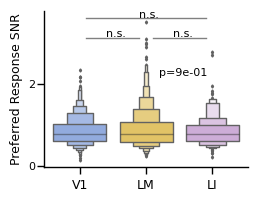

In [132]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_R1_pref_snr_V1, gb_R1_pref_snr_LM, gb_R1_pref_snr_LI],
                palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

_, p_kruskal = stats.kruskal(gb_R1_pref_snr_V1, gb_R1_pref_snr_LM, gb_R1_pref_snr_LI)
plt.text(1.2, 2.2, 'p={:.0e}'.format(p_kruskal), fontsize=8)
print('p_kruskal={:.2e}'.format(p_kruskal))

## add significance stars for posthoc mann whitney u test (Wilcoxon rank-sum test)
_, p_mannwhit_V1LM = stats.mannwhitneyu(gb_R1_pref_snr_V1, gb_R1_pref_snr_LM)
_, p_mannwhit_LMLI = stats.mannwhitneyu(gb_R1_pref_snr_LM, gb_R1_pref_snr_LI)
_, p_mannwhit_V1LI = stats.mannwhitneyu(gb_R1_pref_snr_V1, gb_R1_pref_snr_LI)
p_mannwhit = [p_mannwhit_V1LM, p_mannwhit_LMLI, p_mannwhit_V1LI]
print('p_mannwhit_V1LM={:.2e}'.format(p_mannwhit_V1LM))
print('p_mannwhit_LMLI={:.2e}'.format(p_mannwhit_LMLI))
print('p_mannwhit_V1LI={:.2e}'.format(p_mannwhit_V1LI))

sig_star_str = []
for i, pval in enumerate(p_mannwhit):
    if pval < 0.001:
        sig_star_str.append('***')
    elif pval < 0.01:
        sig_star_str.append('**')
    elif pval < 0.05:
        sig_star_str.append('*')
    else:
        sig_star_str.append('n.s.')

## first, draw horizontal lines to connect pairs of groups
sig_bar_y = 3.1
sig_bar_shorten = 0.1
plt.plot([0+sig_bar_shorten, 1-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
# sig_bar_y += 0.2
plt.plot([1+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
sig_bar_y += 0.5
plt.plot([0+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)

## then, draw significance stars
sig_star_y_base = 3.15
sig_star_y = [sig_star_y_base, sig_star_y_base, sig_star_y_base+0.45]
sig_star_x = [0.4, 1.4, 0.9] # V1-LM, LM-LI, V1-LI
for i, sig_star in enumerate(sig_star_str):
    plt.text(sig_star_x[i], sig_star_y[i], sig_star, fontsize=8)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=9);
plt.ylabel('Preferred Response SNR', fontsize=9);
plt.yticks(fontsize=8);
# yticks = ax.yaxis.get_major_ticks()
# yticks = [float(item.label.get_text()) for item in yticks]
# ax.set_yticklabels(yticks, fontsize=8)

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_R1pref_SNR_by_area_addV1multisess.svg'))

In [133]:
## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
p_dunn_V1LM = sp.posthoc_dunn([gb_R1_pref_snr_V1, gb_R1_pref_snr_LM, ], p_adjust='bonferroni')
p_dunn_V1LI = sp.posthoc_dunn([gb_R1_pref_snr_V1, gb_R1_pref_snr_LI], p_adjust='bonferroni')
p_dunn_LMLI = sp.posthoc_dunn([gb_R1_pref_snr_LM, gb_R1_pref_snr_LI], p_adjust='bonferroni')
p_dunn_V1LM.values[0, 1], p_dunn_V1LI.values[0, 1], p_dunn_LMLI.values[0, 1]

(0.9978939704766814, 0.6077276803109274, 0.6172621221428858)

# fig2a: vis cell % stacked histogram


In [134]:
df_cell_property = df_tidy.groupby('cell_id').first()
df_cell_property['vis_str'] = 'p>=0.05'

nstim = df_tidy.stim2_id.nunique()
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.05 / nstim, 'vis_str'] = '0.01<=p<0.05' # bonferroni correction
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.01 / nstim, 'vis_str'] = 'p<0.01'

df_vis_hist = df_cell_property.groupby('area').vis_str.value_counts().unstack()
df_vis_hist = df_vis_hist.iloc[::-1] # row order: V1, LM, LI
df_vis_hist = df_vis_hist.iloc[:, [2, 0, 1]] # column order: not visually driven -> moderately -> strongly visually driven

df_vis_hist['ncell_total'] = df_vis_hist.sum(axis=1)
print(df_vis_hist)
for col in df_vis_hist.columns[:-1]: # normalize by total cell number in each area
    df_vis_hist[col] = df_vis_hist[col] / df_vis_hist.ncell_total * 100 # convert to percentage
df_vis_hist = df_vis_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total
print(df_vis_hist)

vis_str  p>=0.05  0.01<=p<0.05  p<0.01  ncell_total
area                                               
V1           331           111     262          704
LM          1095           217     403         1715
LI           568            50      73          691
vis_str    p>=0.05  0.01<=p<0.05     p<0.01
area                                       
V1       47.017045     15.767045  37.215909
LM       63.848397     12.653061  23.498542
LI       82.199711      7.235890  10.564399


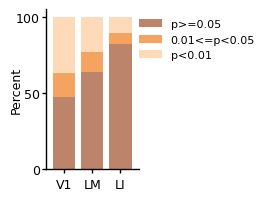

In [135]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2

ax = (df_vis_hist
        .plot(kind='bar', stacked=True,
        figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
        # colormap=ListedColormap(["darkred", "indianred", "lightcoral"]), 
        colormap=ListedColormap(["sienna", "sandybrown", "peachpuff"]), 
        width=0.8) # make bar thinner
        );

## set alpha for darkest color
alpha = 0.7
plt.gca().patches[0].set_alpha(alpha)
plt.gca().patches[1].set_alpha(alpha)
plt.gca().patches[2].set_alpha(alpha)

plt.xticks(rotation=0, fontsize=9); # rotate x tick labels back to horizontal
plt.yticks(fontsize=9); # rotate x tick labels back to horizontal
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xlabel('')
plt.ylabel('Percent', fontsize=9, labelpad=-5);
plt.legend(frameon=False, bbox_to_anchor=(0.9, 1), fontsize=8);
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'vis_cell_by_area_addV1multisess.svg'))

In [136]:
## chi2

df_cell_property = df_tidy.groupby('cell_id').first()
df_cell_property['vis_str'] = 'p>=0.05'

nstim = df_tidy.stim2_id.nunique()
df_cell_property.loc[df_cell_property.filter_cell_vis_pval < 0.05 / nstim, 'vis_str'] = 'p<0.05' # bonferroni correction

df_vis_hist = df_cell_property.groupby('area').vis_str.value_counts().unstack()
df_vis_hist = df_vis_hist.iloc[::-1] # row order: V1, LM, LI

df_vis_hist['ncell_total'] = df_vis_hist.sum(axis=1)
df_vis_hist = df_vis_hist.iloc[:, [0, 1]] # column order: not visually driven -> moderately -> strongly visually driven
print(df_vis_hist)
print('')

for area_pair in [['V1', 'LM'], ['V1', 'LI'], ['LM', 'LI']]:
    df_vis_hist_conting = df_vis_hist.pivot_table(columns='area')
    df_vis_hist_conting = df_vis_hist_conting[area_pair]
    print(df_vis_hist_conting)

    chi2, p, dof, ex = stats.chi2_contingency(df_vis_hist_conting)
    print('p={:.2e}'.format(p))
    print('')

vis_str  p<0.05  p>=0.05
area                    
V1          373      331
LM          620     1095
LI          123      568

area      V1    LM
vis_str           
p<0.05   373   620
p>=0.05  331  1095
p=3.00e-14

area      V1   LI
vis_str          
p<0.05   373  123
p>=0.05  331  568
p=1.55e-42

area       LM   LI
vis_str           
p<0.05    620  123
p>=0.05  1095  568
p=1.84e-18



# fig3a: grand avg trace across areas

In [137]:
dir_mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_fig = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')


def trace_longer_baseline(trace_by_trial, tail_frame_start=180, nframe_plot=90):

    ncell = trace_by_trial.shape[0]
    ntrial = trace_by_trial.shape[1]

    trace_by_trial_tail = trace_by_trial[:, :, tail_frame_start:]
    trace_by_trial_tail = trace_by_trial_tail - ((trace_by_trial[:, :, -1] - trace_by_trial[:, :, 0])).reshape(ncell, ntrial, 1)
    trace_by_trial_head = trace_by_trial[:, :, :tail_frame_start]

    trace_by_trial_reorder = np.concatenate((trace_by_trial_tail, trace_by_trial_head), axis=2)
    trace_by_trial_reorder = trace_by_trial_reorder[:, :, :nframe_plot]

    return trace_by_trial_reorder


def trace_grand_avg_area(df_tidy, select_area='V1', tail_frame_start=180):
    df_fig2 = df_tidy.copy() # df_tidy comes from section "load df tidy"
    df_fig2 = df_fig2[(df_fig2.area == select_area)
                    & (df_fig2.isi == 250) & (df_fig2.stim2_id == 0)
                    & (df_fig2.resp_id == 'R2')
                    & (df_fig2.filter_cell_vis == True)
                    # & (df_fig2.filter_cell_vis_strict == True)
                    ]

    trace_by_cell_concat = np.array([])
    for idatesess in tqdm(df_fig2.datesess.unique()):
        
        df_now = df_fig2[df_fig2.datesess == idatesess]
        try:
            area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + idatesess
            if idatesess == '240229_multisess':
                idatesess = '240229' # remove sess for multisess
                area_imouse_date_sess = df_now.area.unique()[0] + '_i' + df_now.mouse.unique()[0] + '_' + idatesess
            dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
            trace = sio.loadmat(dir_sess_trace)
        except:
            area_imouse_date_sess = area_imouse_date_sess + '_cellpose'
            dir_sess_trace = os.path.join(dir_mat_inter, area_imouse_date_sess, 'trace_trial_stim.mat')
            trace = sio.loadmat(dir_sess_trace)
        trace_by_trial = trace['trace_by_trial']
        trace_by_trial = trace_longer_baseline(trace_by_trial, tail_frame_start=tail_frame_start)

        cell_id = df_now.cell_id.unique()
        cell_id = [item.split('_')[-1] for item in cell_id]
        cell_id = [int(item) for item in cell_id]
        trial_id = df_now.trial_id.unique()

        nframe_keep = 200
        trace_filtered = trace_by_trial[cell_id, :, :nframe_keep]
        trace_filtered = trace_filtered[:, trial_id, :nframe_keep]
        trace_by_cell = np.mean(trace_filtered, axis=1) # ncell x nframe, avg across trials of isi=250, ori=0
        
        if trace_by_cell_concat.size == 0:
            trace_by_cell_concat = trace_by_cell
        else: ## stack trace_by_cell onto trace_by_cell_concat
            trace_by_cell_concat = np.vstack([trace_by_cell_concat, trace_by_cell])

    print(trace_by_cell_concat.shape)
    trace_grand_avg = np.mean(trace_by_cell_concat, axis=0)
    trace_grand_sem = np.std(trace_by_cell_concat, axis=0) / np.sqrt(trace_by_cell_concat.shape[0])

    return trace_grand_avg, trace_grand_sem

In [138]:
frame_shift_sec = 0.5 # keep 0.5 sec of trace tail (baseline) for each trial
frame_rate = 30 # unit = frame/sec
frame_shift = int(frame_shift_sec * frame_rate) # length of trace tail, unit = frame
nframe = 207 # TODO: fix hard code
tail_frame_start = nframe - frame_shift # trace tail starts from this frame
nframe_plot = 90 # number of frames to plot


# trace_avg_V1, trace_sem_V1 = trace_grand_avg_area(df_tidy, select_area='V1', tail_frame_start=tail_frame_start)
# trace_avg_LM, trace_sem_LM = trace_grand_avg_area(df_tidy, select_area='LM', tail_frame_start=tail_frame_start)
# trace_avg_LI, trace_sem_LI = trace_grand_avg_area(df_tidy, select_area='LI', tail_frame_start=tail_frame_start)

# trace_avg_list = [trace_avg_V1, trace_avg_LM, trace_avg_LI]
# trace_sem_list = [trace_sem_V1, trace_sem_LM, trace_sem_LI]
# area_list = ['V1', 'LM', 'LI']
# color_list = ['#85A7EB', '#F6CD51', '#D1A6DE']

# ## save to pickle
# trace_area = {'trace_avg_list': trace_avg_list,
#              'trace_sem_list': trace_sem_list,
#              'area_list': area_list,
#              'color_list': color_list}
# with open(dir_fig + 'trace_area_baseline_500ms_addmultisess_vis_strict.pkl', 'wb') as f:
#     pickle.dump(trace_area, f)


## load from pickle
# with open(dir_fig + 'trace_area_baseline_500ms_addmultisess_vis_strict.pkl', 'rb') as f:
with open(dir_fig + 'trace_area_baseline_500ms_addmultisess.pkl', 'rb') as f:
    trace_area = pickle.load(f)

trace_avg_list = trace_area['trace_avg_list']
trace_sem_list = trace_area['trace_sem_list']
area_list = trace_area['area_list']
color_list = trace_area['color_list']

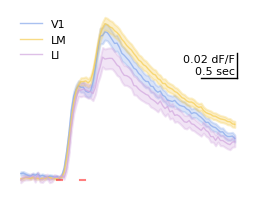

In [140]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2
fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

for iarea, area in enumerate(area_list):
	trace_grand_avg = trace_avg_list[iarea]
	trace_grand_sem = trace_sem_list[iarea]

	plt.plot(trace_grand_avg, 
		  alpha=0.7, linewidth=1, 
		  color=color_list[iarea], 
		  label=area
		  )
	plt.fill_between(np.arange(trace_grand_avg.shape[0]),
			trace_grand_avg - trace_grand_sem, 
			trace_grand_avg + trace_grand_sem,
			alpha=0.3, 
			color=color_list[iarea]
			)


# plot stim-on time
# 100 ms first stim (onset at 0 frame), 30 frame/sec -> 30*0.1 = 3 frames
# after 250 ms ISI, second stim onset: 0.25*30 = 7.5 frames
# 100 ms second stim: 0.1*30 = 3 frames
# first stim bar: frame 0 to frame 2
# second stim bar: frame 9.5 to frame 11.5
stim1_time = np.arange(0, 2, 0.01) + frame_shift
stim2_time = np.arange(9.5, 11.5, 0.01) + frame_shift
y = np.ones(stim1_time.shape) * (-0.001)
plt.plot(stim1_time, y, linewidth=1.5, color='r', alpha=0.5)
plt.plot(stim2_time, y, linewidth=1.5, color='r', alpha=0.5)


## vertical scale bar for df/f
vertical_bar_y_lower = 0.08
vertical_bar_x = trace_grand_avg.shape[0]
plt.plot([vertical_bar_x, vertical_bar_x], 
		 [vertical_bar_y_lower, vertical_bar_y_lower+0.02], 
		 linewidth=1, color='k');

## horizontal scale bar for sec
horiz_bar_len = frame_rate * 0.5
plt.plot([vertical_bar_x - horiz_bar_len, vertical_bar_x], 
		 [vertical_bar_y_lower, vertical_bar_y_lower], 
		 linewidth=1, color='k');

## text on the bottom of the scale bar
text_adjust_left = 1
text_adjust_up = 0.01
plt.text(vertical_bar_x - text_adjust_left, vertical_bar_y_lower+text_adjust_up+0.005, 
		 r'0.02 dF/F', ha='right', va='center', fontsize=8);
plt.text(vertical_bar_x - text_adjust_left, vertical_bar_y_lower+text_adjust_up, 
		 r'0.5 sec', ha='right', va='top', fontsize=8);


plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.axis('off')

plt.legend(frameon=False, fontsize=8);
plt.tight_layout();

# plt.savefig(dir_fig + '/fig2_trace_grand_avg_across_area_addV1multisess.svg')

# filter_cell_vis_R1
among vis_strict cell, filter by R1_ori0 > thresh

In [222]:
df_R1_ori0 = df_tidy[(df_tidy.stim2_id == 0) & (df_tidy.resp_id == 'R1') & (df_tidy.isi == 250)].groupby(['cell_id']).dfof.mean().abs().reset_index()
df_R1_ori0['filter_cell_R1_ori0'] = df_R1_ori0.dfof >= 0.01 # match filter of section "R1 & adp across area"
df_R1_ori0 = df_R1_ori0.drop(columns=['dfof'])

df_vis = df_tidy[['area', 'cell_id', 'filter_cell_vis', 'filter_cell_vis_strict']].groupby('cell_id').first().reset_index()
df_vis_R1_ori0 = df_vis.merge(df_R1_ori0, on='cell_id', how='outer')

df_vis_R1_ori0['both'] = df_vis_R1_ori0.filter_cell_vis_strict & df_vis_R1_ori0.filter_cell_R1_ori0
df_vis_R1_ori0['cell_type'] = 'none'
df_vis_R1_ori0.loc[(df_vis_R1_ori0.filter_cell_vis_strict == True) & (df_vis_R1_ori0.filter_cell_R1_ori0 == False), 'cell_type'] = 'vis_only'
df_vis_R1_ori0.loc[(df_vis_R1_ori0.filter_cell_vis_strict == False) & (df_vis_R1_ori0.filter_cell_R1_ori0 == True), 'cell_type'] = 'R1_ori0_only'
df_vis_R1_ori0.loc[(df_vis_R1_ori0.filter_cell_vis_strict == True) & (df_vis_R1_ori0.filter_cell_R1_ori0 == True), 'cell_type'] = 'both'
df_vis_R1_ori0 = df_vis_R1_ori0[df_vis_R1_ori0.cell_type != 'none']

df_vis_R1 = df_vis_R1_ori0.groupby('area').cell_type.value_counts().unstack()
df_vis_R1 = df_vis_R1.iloc[::-1] # row order: V1, LM, LI
# df_vis_R1 = df_vis_R1.iloc[:, [2,3,0,1]] # column order

df_vis_R1['ncell_total'] = df_vis_R1.sum(axis=1)
print(df_vis_R1)
for col in df_vis_R1.columns[:-1]: # normalize by total cell number in each area
    df_vis_R1[col] = df_vis_R1[col] / df_vis_R1.ncell_total * 100 # convert to percentage
df_vis_hist = df_vis_R1.drop(columns='ncell_total', axis=1) # drop column ncell_total
print(df_vis_R1)

cell_type  R1_ori0_only  both  vis_only  ncell_total
area                                                
V1                  253   337        36          626
LM                  777   569        51         1397
LI                  367   112        11          490
cell_type  R1_ori0_only       both  vis_only  ncell_total
area                                                     
V1            40.415335  53.833866  5.750799          626
LM            55.619184  40.730136  3.650680         1397
LI            74.897959  22.857143  2.244898          490


# fig3b: adaptation across area

In [141]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) ## suppress FutureWarning

def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['cell_id']).dfof.mean().values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2') & (df_filter.isi == 250)].groupby(['cell_id']).dfof.mean().values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    
    gb_adp = gb_adp[(np.abs(gb_R1) >= 0.05)
                    ]
    return gb_adp


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)]
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True)]
gb_adp_V1 = adp_in_area(df_filter[df_filter.area == 'V1'])
gb_adp_LM = adp_in_area(df_filter[df_filter.area == 'LM'])
gb_adp_LI = adp_in_area(df_filter[df_filter.area == 'LI'])

p_kruskal=5.58e-08
p_mannwhit_V1LM=4.08e-02
p_mannwhit_LMLI=1.51e-06
p_mannwhit_V1LI=1.68e-08


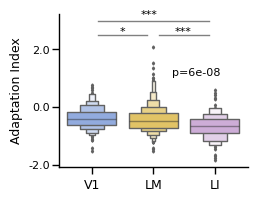

In [216]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_adp_V1, gb_adp_LM, gb_adp_LI],
                palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

_, p_kruskal = stats.kruskal(gb_adp_V1, gb_adp_LM, gb_adp_LI)
plt.text(1.3, 1.1, 'p={:.0e}'.format(p_kruskal), fontsize=8)
print('p_kruskal={:.2e}'.format(p_kruskal))

## add significance stars for posthoc mann whitney u test (Wilcoxon rank-sum test)
_, p_mannwhit_V1LM = stats.mannwhitneyu(gb_adp_V1, gb_adp_LM)
_, p_mannwhit_LMLI = stats.mannwhitneyu(gb_adp_LM, gb_adp_LI)
_, p_mannwhit_V1LI = stats.mannwhitneyu(gb_adp_V1, gb_adp_LI)
p_mannwhit = [p_mannwhit_V1LM, p_mannwhit_LMLI, p_mannwhit_V1LI]
print('p_mannwhit_V1LM={:.2e}'.format(p_mannwhit_V1LM))
print('p_mannwhit_LMLI={:.2e}'.format(p_mannwhit_LMLI))
print('p_mannwhit_V1LI={:.2e}'.format(p_mannwhit_V1LI))

sig_star_str = []
for i, pval in enumerate(p_mannwhit):
    if pval < 0.001:
        sig_star_str.append('***')
    elif pval < 0.01:
        sig_star_str.append('**')
    elif pval < 0.05:
        sig_star_str.append('*')
    else:
        sig_star_str.append('n.s.')

## first, draw horizontal lines to connect pairs of groups
sig_bar_y = 2.5
sig_bar_shorten = 0.1
plt.plot([0+sig_bar_shorten, 1-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
plt.plot([1+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
sig_bar_y += 0.5
plt.plot([0+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)

## then, draw significance stars
sig_star_y_base = sig_bar_y - 0.5
sig_star_y = [sig_star_y_base, sig_star_y_base, sig_star_y_base+0.6]
sig_star_x = [0.45, 1.35, 0.8] # V1-LM, LM-LI, V1-LI
for i, sig_star in enumerate(sig_star_str):
    plt.text(sig_star_x[i], sig_star_y[i], sig_star, fontsize=8)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=9);
plt.ylabel('Adaptation Index', fontsize=9);
# plt.yticks(fontsize=8);
ytickpos = np.arange(-2, 2.1, 2)
ytickstr = ['{:.1f}'.format(item) for item in ytickpos]
ax.set_yticks(ytickpos, labels=ytickstr, fontsize=8)

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_adp_by_area_addV1multisess.svg'))

In [143]:
## normality test
for tmp in [gb_adp_V1, gb_adp_LM, gb_adp_LI]:
    _, p = stats.normaltest(tmp)
    print(p) # null hypothesis: x comes from a normal distribution. p < 0.05 -> not gaussian

## compare adp vs zero: Wilcoxon Rank Sum test (aka Mann–Whitney U test)
(stats.mannwhitneyu(gb_adp_V1, np.zeros_like(gb_adp_V1), alternative='less'), 
stats.mannwhitneyu(gb_adp_LM, np.zeros_like(gb_adp_LM), alternative='less'),
stats.mannwhitneyu(gb_adp_LI, np.zeros_like(gb_adp_LI), alternative='less'))

0.0047181997586328355
1.2206322731451953e-30
0.3252058865514883


(MannwhitneyuResult(statistic=8260.0, pvalue=1.1954424157381753e-45),
 MannwhitneyuResult(statistic=32630.0, pvalue=5.612306899134443e-105),
 MannwhitneyuResult(statistic=672.0, pvalue=2.6531865986637093e-35))

In [144]:
## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
sp.posthoc_dunn([gb_adp_V1, gb_adp_LM], p_adjust='bonferroni'), sp.posthoc_dunn([gb_adp_V1, gb_adp_LI], p_adjust='bonferroni'), sp.posthoc_dunn([gb_adp_LM, gb_adp_LI], p_adjust='bonferroni')

(          1         2
 1  1.000000  0.040809
 2  0.040809  1.000000,
               1             2
 1  1.000000e+00  1.678107e-08
 2  1.678107e-08  1.000000e+00,
           1         2
 1  1.000000  0.000002
 2  0.000002  1.000000)

# fig3c: R1 ori=0 across area

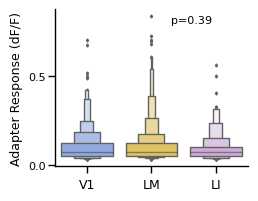

In [146]:
def R1_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1') & (df_filter.isi == 250)].groupby(['area', 'cell_id']).dfof.mean().values # avg over rep trials
    gb_R1 = gb_R1[(np.abs(gb_R1 >= 0.033)) 
                ] # NOTE: use the same cell filter as func adp_in_area
    return gb_R1


df_filter = df_tidy[(df_tidy.filter_cell_vis == True)]
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True)]
gb_R1_V1 = R1_in_area(df_filter[df_filter.area == 'V1'])
gb_R1_LM = R1_in_area(df_filter[df_filter.area == 'LM'])
gb_R1_LI = R1_in_area(df_filter[df_filter.area == 'LI'])

cm_to_in = 1/2.54  # centimeters in inches
scale = 2
ax = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))
ax = sns.boxenplot(data=[gb_R1_V1, gb_R1_LM, gb_R1_LI], 
                palette=['#85A7EB', '#F6CD51', '#D1A6DE'], 
                linewidth=1, flier_kws=dict(s=1),
                )

_, p_kruskal = stats.kruskal(gb_R1_V1, gb_R1_LM, gb_R1_LI)
plt.text(1.3, 0.8, 'p={:.2f}'.format(p_kruskal), fontsize=8)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=9);
plt.ylabel('Adapter Response (dF/F)', fontsize=9);
plt.yticks(fontsize=8);

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=5, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();
plt.tight_layout();

# plt.savefig(os.path.join(dir_fig, 'fig2_R1_by_area_addV1multisess.svg'))

In [147]:
## kruskal wallis test
print(stats.kruskal(gb_R1_V1, gb_R1_LM, gb_R1_LI))

## mann whitney u test (Wilcoxon rank-sum test)
stats.mannwhitneyu(gb_R1_V1, gb_R1_LM), stats.mannwhitneyu(gb_R1_V1, gb_R1_LI), stats.mannwhitneyu(gb_R1_LM, gb_R1_LI)

KruskalResult(statistic=1.9001458548132177, pvalue=0.38671282046302946)


(MannwhitneyuResult(statistic=103005.0, pvalue=0.3682896270044693),
 MannwhitneyuResult(statistic=25036.0, pvalue=0.6205382143944765),
 MannwhitneyuResult(statistic=51166.0, pvalue=0.21415757432336435))

# fig4be: tuning across area & ISI

In [154]:
df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]

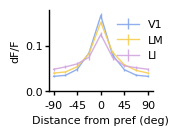

In [156]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]


for i, iarea in enumerate(['V1', 'LM', 'LI']):
    tuning_pop = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_noad.first().values
    tuning_pop_250 = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_250.first().values
    nori = len(tuning_pop[0])
    tuning_pop = np.concatenate(tuning_pop).reshape(-1, nori) # reshape array of arrays to 2d array. ncell x nstim (nori)
    # print(tuning_pop.shape) # ncell x nstim (nori)
    tuning_pop_250 = np.concatenate(tuning_pop_250).reshape(-1, nori)

    ## find pref ori by argmax along ori axis. determined in noad trials
    pref_ori = np.argmax(tuning_pop, axis=1) # ncell

    ## align tuning curve by pref ori
    tuning_pop_aligned = np.zeros_like(tuning_pop)
    tuning_pop_aligned_250 = np.zeros_like(tuning_pop_250)
    for icell in range(tuning_pop.shape[0]):
        tuning_pop_aligned[icell] = np.roll(tuning_pop[icell], nori//2 - pref_ori[icell]) # shift by nori//2 - pref_ori
        tuning_pop_aligned_250[icell] = np.roll(tuning_pop_250[icell], nori//2 - pref_ori[icell]) # align by pref_ori of noad (before adp)

    tuning_pop_avg = np.nanmean(tuning_pop_aligned, axis=0) # average across cells
    tuning_pop_avg = np.append(tuning_pop_avg, tuning_pop_avg[0]) # append first element to the end, so it's a circle
    tuning_pop_avg_250 = np.nanmean(tuning_pop_aligned_250, axis=0)
    tuning_pop_avg_250 = np.append(tuning_pop_avg_250, tuning_pop_avg_250[0])

    tuning_pop_sem = np.nanstd(tuning_pop_aligned, axis=0) / np.sqrt(tuning_pop.shape[0]) # sem across cells
    tuning_pop_sem = np.append(tuning_pop_sem, tuning_pop_sem[0])
    tuning_pop_sem_250 = np.nanstd(tuning_pop_aligned_250, axis=0) / np.sqrt(tuning_pop_250.shape[0])
    tuning_pop_sem_250 = np.append(tuning_pop_sem_250, tuning_pop_sem_250[0])


    ax.errorbar(np.arange(len(tuning_pop_avg)),
                tuning_pop_avg, 
                yerr=tuning_pop_sem, 
                label=iarea, alpha=0.9, linewidth=1, 
                color=color_list_noad[i],)
    
    # ax[1].errorbar(np.arange(len(tuning_pop_avg_250)),
    #             tuning_pop_avg_250, 
    #             yerr=tuning_pop_sem_250, 
    #             label=iarea, alpha=.7, linewidth=1, 
    #             color=color_list_250[i],)

xlabels = [str(int(t)) for t in np.arange(-90, 90 + 180/nori*2, 180/nori*2)]
ax.set_xticks(np.arange(0, len(tuning_pop_avg), 2), xlabels, fontsize=8);
ylim_upper = ax.get_ylim()[1]
yticks = np.arange(0, ylim_upper, 0.1)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);

ax.set_xlabel('Distance from pref (deg)', fontsize=8)
ax.set_ylabel('dF/F', fontsize=8)
ax.legend(frameon=False, loc='upper right', fontsize=8, bbox_to_anchor=(1.2, 1));

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

sns.despine();
# fig.savefig(os.path.join(dir_fig, 'tuning_curve_R1_by_area_addV1multisess.svg'), bbox_inches='tight')

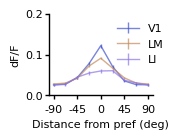

In [157]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]


for i, iarea in enumerate(['V1', 'LM', 'LI']):
    tuning_pop = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_noad.first().values
    tuning_pop_250 = df_filter[df_filter.area == iarea].groupby(['cell_id']).tuning_250.first().values
    nori = len(tuning_pop[0])
    tuning_pop = np.concatenate(tuning_pop).reshape(-1, nori) # reshape array of arrays to 2d array. ncell x nstim (nori)
    # print(tuning_pop.shape) # ncell x nstim (nori)
    tuning_pop_250 = np.concatenate(tuning_pop_250).reshape(-1, nori)

    ## find pref ori by argmax along ori axis. determined in noad trials
    pref_ori = np.argmax(tuning_pop, axis=1) # ncell

    ## align tuning curve by pref ori
    tuning_pop_aligned = np.zeros_like(tuning_pop)
    tuning_pop_aligned_250 = np.zeros_like(tuning_pop_250)
    for icell in range(tuning_pop.shape[0]):
        tuning_pop_aligned[icell] = np.roll(tuning_pop[icell], nori//2 - pref_ori[icell]) # shift by nori//2 - pref_ori
        tuning_pop_aligned_250[icell] = np.roll(tuning_pop_250[icell], nori//2 - pref_ori[icell]) # align by pref_ori of noad (before adp)

    tuning_pop_avg = np.nanmean(tuning_pop_aligned, axis=0) # average across cells
    tuning_pop_avg = np.append(tuning_pop_avg, tuning_pop_avg[0]) # append first element to the end, so it's a circle
    tuning_pop_avg_250 = np.nanmean(tuning_pop_aligned_250, axis=0)
    tuning_pop_avg_250 = np.append(tuning_pop_avg_250, tuning_pop_avg_250[0])

    tuning_pop_sem = np.nanstd(tuning_pop_aligned, axis=0) / np.sqrt(tuning_pop.shape[0]) # sem across cells
    tuning_pop_sem = np.append(tuning_pop_sem, tuning_pop_sem[0])
    tuning_pop_sem_250 = np.nanstd(tuning_pop_aligned_250, axis=0) / np.sqrt(tuning_pop_250.shape[0])
    tuning_pop_sem_250 = np.append(tuning_pop_sem_250, tuning_pop_sem_250[0])


    # ax.errorbar(np.arange(len(tuning_pop_avg)),
    #             tuning_pop_avg, 
    #             yerr=tuning_pop_sem, 
    #             label=iarea, alpha=0.9, linewidth=1, 
    #             color=color_list_noad[i],)
    
    ax.errorbar(np.arange(len(tuning_pop_avg_250)),
                tuning_pop_avg_250, 
                yerr=tuning_pop_sem_250, 
                label=iarea, alpha=.7, linewidth=1, 
                color=color_list_250[i],)

xlabels = [str(int(t)) for t in np.arange(-90, 90 + 180/nori*2, 180/nori*2)]
ax.set_xticks(np.arange(0, len(tuning_pop_avg), 2), xlabels, fontsize=8);
ylim_upper = 0.2 # taken from tuning_curve_by_area_vis_R1_figsize
yticks = np.arange(0, ylim_upper+0.05, 0.1)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);

ax.set_xlabel('Distance from pref (deg)', fontsize=8)
ax.set_ylabel('dF/F', fontsize=8)
ax.legend(frameon=False, loc='upper right', fontsize=8, bbox_to_anchor=(1.2, 1));

ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

sns.despine();
# fig.savefig(os.path.join(dir_fig, 'tuning_curve_R2_by_area_addV1multisess.svg'), bbox_inches='tight')

# fig4cf: gOSI across areas
calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)   
[Ukita 2020](https://www.sciencedirect.com/science/article/pii/S089360802030054X)  
no rerun, runtime 22 min

In [171]:
# for icell in tqdm(df_tuning.cell_id.unique()): # NOTE: df_tuning cells already passed R1-ori0 filter. takes 5 min
#     df_cell = df_tuning[df_tuning.cell_id == icell]

#     # tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
#     # tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

#     ## convert tuning_isi from a string of list to an actual list
#     tuning_noad = df_tuning[df_tuning.cell_id == icell].tuning_noad.values[0]
#     if type(tuning_noad) == str:
#         tuning_noad = tuning_noad.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
#         tuning_noad = [float(i) for i in tuning_noad if len(i) > 0] # remove empty string
#     tuning_noad = np.array(tuning_noad) - min(tuning_noad) # ensure all values are non negative

#     tuning_250 = df_tuning[df_tuning.cell_id == icell].tuning_250.values[0]
#     if type(tuning_250) == str:
#         tuning_250 = tuning_250.replace('[', '').replace(']', '').replace('  ', ' ').replace('\n', '').strip().split(' ')
#         tuning_250 = [float(i) for i in tuning_250 if len(i) > 0]
#     tuning_250 = np.array(tuning_250) - min(tuning_250)


#     theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
#     sin_arr = np.sin(2 * theta_arr)
#     cos_arr = np.cos(2 * theta_arr)

#     gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
#     gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

#     df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
#     df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

# df_tuning = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False)

100%|██████████| 3110/3110 [22:15<00:00,  2.33it/s]


In [158]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_visp_addmultisess_gosi.csv'
# df_tuning.to_csv(os.path.join(dir_data, csv_filename), index=False) # 2 min
df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_23052\741252033.py:4: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))


In [159]:
df_filter = df_tuning[(df_tuning.filter_cell_vis == True)]
# df_filter = df_tuning[(df_tuning.filter_cell_vis_strict == True)]

df_gOSI = df_filter.groupby('cell_id', sort=False)[['area', 
                                                    'gOSI_noad', 'gOSI_250']
                                                    ].first().reset_index()
df_gOSI.sample(5, random_state=0)

,cell_id,area,gOSI_noad,gOSI_250
1610,211020_003_39,LM,0.156247,0.375979
1269,230228_003_7,LI,0.327180,0.429208
1722,230307_004_78,LM,0.047705,0.157330
161,201127_002_2,LM,0.717021,0.733124
520,200804_003_30,LM,0.585771,0.454926


In [160]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
# color_list_250 = color_list[1::2]
color_list_250 = ['#7784db', '#d5ad8b', '#ae9eed'] # color-picker from tuning curve by area and isi

isi_now = 6000
# isi_now = 250

if isi_now == 6000:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_noad.values
    gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_noad.values
    gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_noad.values
    palette = color_list_noad
elif isi_now == 250:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_250.values
    gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_250.values
    gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_250.values
    palette = color_list_250

p_kruskal=1.10e-19
p_mannwhit_V1LM=6.81e-05
p_mannwhit_LMLI=7.49e-20
p_mannwhit_V1LI=1.58e-09


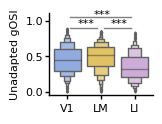

In [161]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

sns.boxenplot(data=[gOSI_V1, gOSI_LM, gOSI_LI], 
            palette=palette, 
            linewidth=1, 
            flier_kws=dict(s=1), 
            ax=ax,
            )

## set alpha
if isi_now == 250:
    for violin in ax.collections[::2]:
        violin.set_alpha(0.6)
    plt.setp(ax.lines, alpha=.6)

## add pvlaue for kruskal wallis test (non-parametric ANOVA)
_, p_kruskal = stats.kruskal(gOSI_V1, gOSI_LM, gOSI_LI)
# plt.text(0.45, 0.03, 'p={:.0e}'.format(p_kruskal), fontsize=8)
print('p_kruskal={:.2e}'.format(p_kruskal))

## add significance stars for posthoc mann whitney u test (Wilcoxon rank-sum test)
_, p_mannwhit_V1LM = stats.mannwhitneyu(gOSI_V1, gOSI_LM)
_, p_mannwhit_LMLI = stats.mannwhitneyu(gOSI_LM, gOSI_LI)
_, p_mannwhit_V1LI = stats.mannwhitneyu(gOSI_V1, gOSI_LI)
p_mannwhit = [p_mannwhit_V1LM, p_mannwhit_LMLI, p_mannwhit_V1LI]
print('p_mannwhit_V1LM={:.2e}'.format(p_mannwhit_V1LM))
print('p_mannwhit_LMLI={:.2e}'.format(p_mannwhit_LMLI))
print('p_mannwhit_V1LI={:.2e}'.format(p_mannwhit_V1LI))

sig_star_str = []
for i, pval in enumerate(p_mannwhit):
    if pval < 0.001:
        sig_star_str.append('***')
    elif pval < 0.01:
        sig_star_str.append('**')
    elif pval < 0.05:
        sig_star_str.append('*')
    else:
        sig_star_str.append('n.s.')

## first, draw horizontal lines to connect pairs of groups
sig_bar_y = 0.9
sig_bar_shorten = 0.1
plt.plot([0+sig_bar_shorten, 1-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
plt.plot([1+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
sig_bar_y += 0.15
plt.plot([0+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)

## then, draw significance stars
sig_star_y_base = 0.92
sig_star_y = [sig_star_y_base, sig_star_y_base, sig_star_y_base+0.12]
sig_star_x = [0.3, 1.3, 0.8] # V1-LM, LM-LI, V1-LI
for i, sig_star in enumerate(sig_star_str):
    plt.text(sig_star_x[i], sig_star_y[i], sig_star, fontsize=8)


ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();

ylim_upper = ax.get_ylim()[1]
yticks = np.arange(0, ylim_upper, 0.5)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);
ax.set_ylabel('dF/F', fontsize=8)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=8);
if isi_now == 6000:
    isi_str = 'Unadapted'
elif isi_now == 250:
    isi_str = 'Adapted'
plt.ylabel(f'{isi_str} gOSI', fontsize=8);

# plt.savefig(os.path.join(dir_fig, f'gOSI_across_area_{isi_now}ms_addV1multisess.svg'), bbox_inches='tight')

In [162]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # originally https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4, changed last color
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
# color_list_250 = color_list[1::2]
color_list_250 = ['#7784db', '#d5ad8b', '#ae9eed'] # color-picker from tuning curve by area and isi

# isi_now = 6000
isi_now = 250

if isi_now == 6000:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_noad.values
    gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_noad.values
    gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_noad.values
    palette = color_list_noad
elif isi_now == 250:
    gOSI_V1 = df_gOSI[df_gOSI.area == 'V1'].gOSI_250.values
    gOSI_LM = df_gOSI[df_gOSI.area == 'LM'].gOSI_250.values
    gOSI_LI = df_gOSI[df_gOSI.area == 'LI'].gOSI_250.values
    palette = color_list_250

p_kruskal=2.80e-13
p_mannwhit_V1LM=1.53e-01
p_mannwhit_LMLI=5.68e-14
p_mannwhit_V1LI=4.55e-10


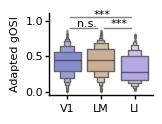

In [163]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 1, 
                       figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
                       sharex=True, sharey=True)

sns.boxenplot(data=[gOSI_V1, gOSI_LM, gOSI_LI], 
            palette=palette, 
            linewidth=1, 
            flier_kws=dict(s=1), 
            ax=ax,
            )

## set alpha
if isi_now == 250:
    for violin in ax.collections[::2]:
        violin.set_alpha(0.6)
    plt.setp(ax.lines, alpha=.6)

## add pvlaue for kruskal wallis test (non-parametric ANOVA)
_, p_kruskal = stats.kruskal(gOSI_V1, gOSI_LM, gOSI_LI)
# plt.text(0.45, 0.03, 'p={:.0e}'.format(p_kruskal), fontsize=8)
print('p_kruskal={:.2e}'.format(p_kruskal))

## add significance stars for posthoc mann whitney u test (Wilcoxon rank-sum test)
_, p_mannwhit_V1LM = stats.mannwhitneyu(gOSI_V1, gOSI_LM)
_, p_mannwhit_LMLI = stats.mannwhitneyu(gOSI_LM, gOSI_LI)
_, p_mannwhit_V1LI = stats.mannwhitneyu(gOSI_V1, gOSI_LI)
p_mannwhit = [p_mannwhit_V1LM, p_mannwhit_LMLI, p_mannwhit_V1LI]
print('p_mannwhit_V1LM={:.2e}'.format(p_mannwhit_V1LM))
print('p_mannwhit_LMLI={:.2e}'.format(p_mannwhit_LMLI))
print('p_mannwhit_V1LI={:.2e}'.format(p_mannwhit_V1LI))

sig_star_str = []
for i, pval in enumerate(p_mannwhit):
    if pval < 0.001:
        sig_star_str.append('***')
    elif pval < 0.01:
        sig_star_str.append('**')
    elif pval < 0.05:
        sig_star_str.append('*')
    else:
        sig_star_str.append('n.s.')

## first, draw horizontal lines to connect pairs of groups
sig_bar_y = 0.9
sig_bar_shorten = 0.1
plt.plot([0+sig_bar_shorten, 1-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
plt.plot([1+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)
sig_bar_y += 0.15
plt.plot([0+sig_bar_shorten, 2-sig_bar_shorten], [sig_bar_y, sig_bar_y], 'gray', linewidth=1)

## then, draw significance stars
sig_star_y_base = 0.92
sig_star_y = [sig_star_y_base, sig_star_y_base, sig_star_y_base+0.12]
sig_star_x = [0.3, 1.3, 0.8] # V1-LM, LM-LI, V1-LI
for i, sig_star in enumerate(sig_star_str):
    plt.text(sig_star_x[i], sig_star_y[i], sig_star, fontsize=8)


ax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
ax.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)
sns.despine();

ylim_upper = ax.get_ylim()[1]
yticks = np.arange(0, ylim_upper, 0.5)
yticklabels = [str(round(t, 1)) for t in yticks]
ax.set_yticks(yticks, yticklabels, fontsize=8);
ax.set_ylabel('dF/F', fontsize=8)

plt.xticks([0, 1, 2], ['V1', 'LM', 'LI'], fontsize=8);
if isi_now == 6000:
    isi_str = 'Unadapted'
elif isi_now == 250:
    isi_str = 'Adapted'
plt.ylabel(f'{isi_str} gOSI', fontsize=8);

# plt.savefig(os.path.join(dir_fig, f'gOSI_across_area_{isi_now}ms_addV1multisess.svg'), bbox_inches='tight')

In [164]:
## post hoc
stats.mannwhitneyu(gOSI_V1, gOSI_LM), stats.mannwhitneyu(gOSI_V1, gOSI_LI), stats.mannwhitneyu(gOSI_LM, gOSI_LI)

(MannwhitneyuResult(statistic=251305.0, pvalue=0.15343956988769764),
 MannwhitneyuResult(statistic=76460.0, pvalue=4.553472324009892e-10),
 MannwhitneyuResult(statistic=144308.0, pvalue=5.683918360982705e-14))

In [165]:
## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
sp.posthoc_dunn([gOSI_V1, gOSI_LM], p_adjust='bonferroni'), sp.posthoc_dunn([gOSI_V1, gOSI_LI], p_adjust='bonferroni'), sp.posthoc_dunn([gOSI_LM, gOSI_LI], p_adjust='bonferroni')

(          1         2
 1  1.000000  0.153422
 2  0.153422  1.000000,
               1             2
 1  1.000000e+00  4.548166e-10
 2  4.548166e-10  1.000000e+00,
               1             2
 1  1.000000e+00  5.679282e-14
 2  5.679282e-14  1.000000e+00)

## gOSI across isi

In [166]:
gOSI_V1_6000 = df_gOSI[df_gOSI.area == 'V1'].gOSI_noad.values
gOSI_LM_6000 = df_gOSI[df_gOSI.area == 'LM'].gOSI_noad.values
gOSI_LI_6000 = df_gOSI[df_gOSI.area == 'LI'].gOSI_noad.values

gOSI_V1_250 = df_gOSI[df_gOSI.area == 'V1'].gOSI_250.values
gOSI_LM_250 = df_gOSI[df_gOSI.area == 'LM'].gOSI_250.values
gOSI_LI_250 = df_gOSI[df_gOSI.area == 'LI'].gOSI_250.values

## paired t test
(stats.ttest_rel(gOSI_V1_6000, gOSI_V1_250, alternative='greater'), # expect gOSI to be higher when isi=6000
 stats.ttest_rel(gOSI_LM_6000, gOSI_LM_250, alternative='greater'), 
 stats.ttest_rel(gOSI_LI_6000, gOSI_LI_250, alternative='greater'))

(TtestResult(statistic=3.7509184310914763, pvalue=9.772812281001298e-05, df=534),
 TtestResult(statistic=8.823651731139817, pvalue=2.4927791819671295e-18, df=982),
 TtestResult(statistic=2.1133123460793906, pvalue=0.017847820997393803, df=221))

# fig4dg: well-max cell % stacked histogram

In [194]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_visp_addmultisess_gosi.csv'
df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_44832\1520611008.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tuning = pd.read_csv(os.path.join(dir_data, csv_filename))


### well-max, ISI 6000

In [167]:
df_cell_property = (df_tuning[(df_tuning.filter_cell_vis == True) 
# df_cell_property = (df_tuning[(df_tuning.filter_cell_vis_strict == True) 
                              & (df_tuning.isi == 6000)] # NOTE: well max percent within vis cells, based on R1 (isi 6k)
                    .groupby('cell_id').first())

df_cell_property['well_str'] = 'none'
df_cell_property.loc[(df_cell_property.filter_cell_well_max == True), 'well_str'] = 'well-tuned' # aka well-max, aka consistent-max

df_well_hist = df_cell_property.groupby('area')[['well_str']].value_counts().unstack()
df_well_hist = df_well_hist.iloc[::-1] # row order: V1, LM, LI
# df_well_hist = df_well_hist.iloc[:, [1, 0]] # column order

df_well_hist['ncell_total'] = df_well_hist.sum(axis=1)
print(df_well_hist)

for col in df_well_hist.columns[:-1]: # normalize by total cell number in each area
    df_well_hist[col] = df_well_hist[col] / df_well_hist.ncell_total * 100 # convert to percentage
df_well_hist = df_well_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total
df_well_hist

well_str  none  well-tuned  ncell_total
area                                   
V1         185         350          535
LM         405         578          983
LI         126          96          222


well_str,none,well-tuned
area,,
V1,34.579439,65.420561
LM,41.200407,58.799593
LI,56.756757,43.243243


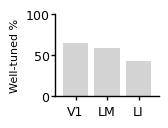

In [168]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1

ax = (df_well_hist['well-tuned']
        .plot(kind='bar', stacked=True,
        figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
        # colormap=ListedColormap(["teal", "darkturquoise", "turquoise", 'aquamarine']), 
        colormap=ListedColormap(['lightgray']), 
        width=0.8) # make bar thinner
        );

# ## set alpha for darkest color
# alpha = 0.7
# plt.gca().patches[0].set_alpha(alpha)
# plt.gca().patches[1].set_alpha(alpha)
# plt.gca().patches[2].set_alpha(alpha)

plt.xticks(rotation=0, fontsize=9); # rotate x tick labels back to horizontal
plt.yticks([0, 50, 100], fontsize=9);
plt.ylim([0, 100])
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xlabel('')
plt.ylabel('Well-tuned %', fontsize=8, ); # labelpad=-5
# plt.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=8);
sns.despine();
# plt.savefig(os.path.join(dir_fig, 'wellmax_in_vis_ncell_by_area_addV1multisess.svg'), bbox_inches='tight')

In [169]:
df_well_hist_conting = df_well_hist.pivot_table(columns='area')
chi2, p, dof, ex = stats.chi2_contingency(df_well_hist_conting)
p

0.0052176505953157905

In [170]:
df_cell_property = (df_tuning[(df_tuning.filter_cell_vis == True) 
# df_cell_property = (df_tuning[(df_tuning.filter_cell_vis_strict == True) 
                            & (df_tuning.isi == 6000)] 
                    .groupby('cell_id').first()) # NOTE: well max percent within vis cells, based on R1 (isi 6k)

df_cell_property['well_str'] = 'none'
df_cell_property.loc[(df_cell_property.filter_cell_well_max == True), 'well_str'] = 'well-tuned' # aka well-max, aka consistent-max


df_well_hist = df_cell_property.groupby('area')[['well_str']].value_counts().unstack()
df_well_hist = df_well_hist.iloc[::-1] # row order: V1, LM, LI

df_well_hist['ncell_total'] = df_well_hist.sum(axis=1)
df_well_hist = df_well_hist.iloc[:, [0, 1]] # column order
print(df_well_hist)
print('')

for area_pair in [['V1', 'LM'], ['V1', 'LI'], ['LM', 'LI']]:
    df_vis_hist_conting = df_well_hist.pivot_table(columns='area')
    df_vis_hist_conting = df_vis_hist_conting[area_pair]
    print(df_vis_hist_conting)

    chi2, p, dof, ex = stats.chi2_contingency(df_vis_hist_conting)
    print('p={:.2e}'.format(p))
    print('')

well_str  none  well-tuned
area                      
V1         185         350
LM         405         578
LI         126          96

area         V1   LM
well_str            
none        185  405
well-tuned  350  578
p=1.34e-02

area         V1   LI
well_str            
none        185  126
well-tuned  350   96
p=2.62e-08

area         LM   LI
well_str            
none        405  126
well-tuned  578   96
p=3.44e-05



### well-max, ISI 250

In [171]:
df_cell_property = (df_tuning[(df_tuning.filter_cell_vis == True) 
# df_cell_property = (df_tuning[(df_tuning.filter_cell_vis_strict == True) 
                              & (df_tuning.isi == 250)] # NOTE: well max percent within vis cells, based on R2 (isi 250)
                    .groupby('cell_id').first())

df_cell_property['well_str'] = 'none'
df_cell_property.loc[(df_cell_property.filter_cell_well_max == True), 'well_str'] = 'well-tuned' # aka well-max, aka consistent-max

df_well_hist = df_cell_property.groupby('area')[['well_str']].value_counts().unstack()
df_well_hist = df_well_hist.iloc[::-1] # row order: V1, LM, LI
# df_well_hist = df_well_hist.iloc[:, [1, 0]] # column order

df_well_hist['ncell_total'] = df_well_hist.sum(axis=1)
print(df_well_hist)

for col in df_well_hist.columns[:-1]: # normalize by total cell number in each area
    df_well_hist[col] = df_well_hist[col] / df_well_hist.ncell_total * 100 # convert to percentage
df_well_hist = df_well_hist.drop(columns='ncell_total', axis=1) # drop column ncell_total
df_well_hist

well_str  none  well-tuned  ncell_total
area                                   
V1         204         331          535
LM         451         532          983
LI         110         112          222


well_str,none,well-tuned
area,,
V1,38.130841,61.869159
LM,45.879959,54.120041
LI,49.549550,50.450450


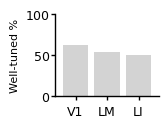

In [172]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1

ax = (df_well_hist['well-tuned']
        .plot(kind='bar', stacked=True,
        figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale), 
        # colormap=ListedColormap(["teal", "darkturquoise", "turquoise", 'aquamarine']), 
        colormap=ListedColormap(['lightgray']), 
        width=0.8) # make bar thinner
        );

# ## set alpha for darkest color
# alpha = 0.7
# plt.gca().patches[0].set_alpha(alpha)
# plt.gca().patches[1].set_alpha(alpha)
# plt.gca().patches[2].set_alpha(alpha)

plt.xticks(rotation=0, fontsize=9); # rotate x tick labels back to horizontal
plt.yticks([0, 50, 100], fontsize=9);
plt.ylim([0, 100])
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xlabel('')
plt.ylabel('Well-tuned %', fontsize=8, ); # labelpad=-5
# plt.legend(frameon=False, bbox_to_anchor=(1, 1), fontsize=8);
sns.despine();

# plt.savefig(os.path.join(dir_fig, 'wellmax_in_vis_ncell_by_area_addV1multisess_isi250.svg'), bbox_inches='tight')

In [173]:
df_well_hist_conting = df_well_hist.pivot_table(columns='area')
chi2, p, dof, ex = stats.chi2_contingency(df_well_hist_conting)
p

0.2526195549638619

In [175]:
df_cell_property = (df_tuning[(df_tuning.filter_cell_vis == True) 
# df_cell_property = (df_tuning[(df_tuning.filter_cell_vis_strict == True) 
                              & (df_tuning.isi == 250)] 
                    .groupby('cell_id').first()) # NOTE: well max percent within vis cells, based on R1 (isi 6k)

df_cell_property['well_str'] = 'none'
df_cell_property.loc[(df_cell_property.filter_cell_well_max == True), 'well_str'] = 'well-tuned' # aka well-max, aka consistent-max


df_well_hist = df_cell_property.groupby('area')[['well_str']].value_counts().unstack()
df_well_hist = df_well_hist.iloc[::-1] # row order: V1, LM, LI

df_well_hist['ncell_total'] = df_well_hist.sum(axis=1)
df_well_hist = df_well_hist.iloc[:, [0, 1]] # column order
print(df_well_hist)
print('')

for area_pair in [['V1', 'LM'], ['V1', 'LI'], ['LM', 'LI']]:
    df_vis_hist_conting = df_well_hist.pivot_table(columns='area')
    df_vis_hist_conting = df_vis_hist_conting[area_pair]
    print(df_vis_hist_conting)

    chi2, p, dof, ex = stats.chi2_contingency(df_vis_hist_conting)
    print('p={:.2e}'.format(p))
    print('')

well_str  none  well-tuned
area                      
V1         204         331
LM         451         532
LI         110         112

area         V1   LM
well_str            
none        204  451
well-tuned  331  532
p=4.26e-03

area         V1   LI
well_str            
none        204  110
well-tuned  331  112
p=4.77e-03

area         LM   LI
well_str            
none        451  110
well-tuned  532  112
p=3.60e-01



# fig4h: tuning bias like plot for (g)OSI
for vis + well-tuned cells

In [96]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_visp_addmultisess_gosi.csv'
df_tidy = pd.read_csv(os.path.join(dir_data, csv_filename))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_23052\3429901358.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tidy = pd.read_csv(os.path.join(dir_data, csv_filename))


In [176]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True) 
                    & (df_tidy.filter_cell_well_max == True)
                    ]
df_filter['gOSI_change'] = df_filter.gOSI_250 - df_filter.gOSI_noad
df_filter = df_filter.groupby('cell_id').first().reset_index()
df_pref_unadapted_distance_bin = df_filter.groupby('cell_id').pref_unadapted_distance_bin.first().reset_index()

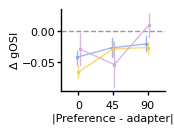

In [178]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

ax = sns.pointplot(x='pref_unadapted_distance_bin', y='gOSI_change', data=df_filter, 
                   hue='area', hue_order=['V1', 'LM', 'LI'],
                   dodge=True, markers='.', scale = 0.3,
                   palette=color_list_noad,
                   errorbar=('ci', 68),
                   )
plt.axhline(0, color='gray', linestyle='--', alpha=.3);

# ypos_sig = 0.05
# ax.text(0.08, ypos_sig-0.03, '***', transform=ax.transAxes, fontsize=8)
# ax.text(0.42, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)
# ax.text(0.75, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)

plt.setp(ax.collections, alpha=1);
plt.setp(ax.lines, alpha=.8, linewidth=1);
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (padding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.xlabel('|Preference - adapter|', fontsize=8, labelpad=2);
plt.ylabel('Δ gOSI', fontsize=8, labelpad=1);
ax.get_legend().remove()
# plt.legend(frameon=False, fontsize=8, 
#         #    loc='upper right', 
#            bbox_to_anchor=(1, 0.8)
#            );
sns.despine();
# plt.savefig(os.path.join(dir_fig, 'gOSI_delta_wellmax_by_area_addV1multisess.svg'), bbox_inches='tight')

In [179]:
df_gOSI = df_filter.copy()
stats.kruskal(df_gOSI[df_gOSI.area == 'V1'].gOSI_change, 
              df_gOSI[df_gOSI.area == 'LM'].gOSI_change, 
              df_gOSI[df_gOSI.area == 'LI'].gOSI_change)

print(stats.kruskal(df_gOSI[(df_gOSI.area == 'V1') & (df_gOSI.pref_unadapted_distance_bin == 0)].gOSI_change,
                df_gOSI[(df_gOSI.area == 'LM') & (df_gOSI.pref_unadapted_distance_bin == 0)].gOSI_change,
                df_gOSI[(df_gOSI.area == 'LI') & (df_gOSI.pref_unadapted_distance_bin == 0)].gOSI_change))

print(stats.kruskal(df_gOSI[(df_gOSI.area == 'V1') & (df_gOSI.pref_unadapted_distance_bin == 45)].gOSI_change,
                df_gOSI[(df_gOSI.area == 'LM') & (df_gOSI.pref_unadapted_distance_bin == 45)].gOSI_change,
                df_gOSI[(df_gOSI.area == 'LI') & (df_gOSI.pref_unadapted_distance_bin == 45)].gOSI_change))
              
print(stats.kruskal(df_gOSI[(df_gOSI.area == 'V1') & (df_gOSI.pref_unadapted_distance_bin == 90)].gOSI_change,
                    df_gOSI[(df_gOSI.area == 'LM') & (df_gOSI.pref_unadapted_distance_bin == 90)].gOSI_change,
                    df_gOSI[(df_gOSI.area == 'LI') & (df_gOSI.pref_unadapted_distance_bin == 90)].gOSI_change))

KruskalResult(statistic=2.935203385565046, pvalue=0.2304775789178879)
KruskalResult(statistic=0.6893873581198022, pvalue=0.7084373294227142)
KruskalResult(statistic=2.6704027197561118, pvalue=0.26310519129253085)


In [180]:
## do two-way anova, across areas and distance bins
## https://www.statology.org/two-way-anova-python/

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('gOSI_change ~ C(pref_unadapted_distance_bin) + C(area) + C(pref_unadapted_distance_bin):C(area)', data=df_gOSI).fit()
sm.stats.anova_lm(model, typ=2) # pval can be found in PR(>F) column

,sum_sq,df,F,PR(>F)
C(pref_unadapted_distance_bin),0.354310,2.0,6.212388,0.002062
C(area),0.112173,2.0,1.966820,0.140298
C(pref_unadapted_distance_bin):C(area),0.104270,4.0,0.914120,0.454813
Residual,38.896431,1364.0,NaN,NaN


# fig4i: tuning bias plot

In [258]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_tuning_wellmax_visp_addmultisess_gosi.csv'
df_tidy = pd.read_csv(os.path.join(dir_data, csv_filename))

C:\Users\ll357\AppData\Local\Temp\7\ipykernel_44832\3429901358.py:3: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_tidy = pd.read_csv(os.path.join(dir_data, csv_filename))


In [181]:
df_filter = df_tidy[(df_tidy.filter_cell_vis == True) 
# df_filter = df_tidy[(df_tidy.filter_cell_vis_strict == True) 
                    & (df_tidy.filter_cell_well_max == True)
                    & (df_tidy.isi == 250)
                    ]
df_filter = df_filter.groupby('cell_id').first().reset_index() # drop duplicate cell_id
df_filter.groupby('area').cell_id.nunique()

area
LI    112
LM    532
V1    331
Name: cell_id, dtype: int64

In [182]:
bias_0_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'V1')].tuning_bias.values
bias_0_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LM')].tuning_bias.values
bias_0_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 0) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_0_V1, bias_0_LM, bias_0_LI))

bias_45_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'V1')].tuning_bias.values
bias_45_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LM')].tuning_bias.values
bias_45_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 45) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_45_V1, bias_45_LM, bias_45_LI))

bias_90_V1 = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'V1')].tuning_bias.values
bias_90_LM = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LM')].tuning_bias.values
bias_90_LI = df_filter[(df_filter.pref_unadapted_distance_bin == 90) & (df_filter.area == 'LI')].tuning_bias.values
print(stats.kruskal(bias_90_V1, bias_90_LM, bias_90_LI))

KruskalResult(statistic=22.038542279772916, pvalue=1.6382921464013074e-05)
KruskalResult(statistic=4.1828449485057355, pvalue=0.12351131912834631)
KruskalResult(statistic=3.5635496255100176, pvalue=0.1683391115785165)


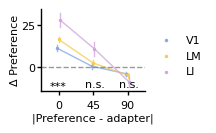

In [183]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig = plt.figure(figsize=(3.404 * cm_to_in * scale, 2.692 * cm_to_in * scale))

ax = sns.pointplot(x='pref_unadapted_distance_bin', y='tuning_bias', data=df_filter, hue='area',
                   dodge=True, markers='.', scale = 0.3,
                   palette=['#85A7EB', '#F6CD51', '#D1A6DE'],
                   errorbar=('ci', 68),
                   )
plt.axhline(0, color='gray', linestyle='--', alpha=.3);

ypos_sig = 0.05
ax.text(0.08, ypos_sig-0.03, '***', transform=ax.transAxes, fontsize=8)
ax.text(0.42, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)
ax.text(0.75, ypos_sig, 'n.s.', transform=ax.transAxes, fontsize=8)

plt.setp(ax.collections, alpha=1);
plt.setp(ax.lines, alpha=.8, linewidth=1);
plt.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
plt.tick_params(direction='out', length=3, width=1)
ax.spines['left'].set_linewidth(1) # set axis width
ax.spines['bottom'].set_linewidth(1)

plt.xticks(fontsize=8);
plt.yticks(fontsize=8);
plt.xlabel('|Preference - adapter|', fontsize=8, labelpad=2);
plt.ylabel('Δ Preference', fontsize=8, labelpad=1);
plt.legend(frameon=False, fontsize=8, 
        #    loc='upper right', 
           bbox_to_anchor=(1, 0.8)
           );
sns.despine();
# plt.savefig(os.path.join(dir_fig, 'tuning_bias_wellmax_by_area_addV1multisess.svg'), bbox_inches='tight')

## stats

In [184]:
## dunn test (posthoc test for kruskal wallis): https://scikit-posthocs.readthedocs.io/en/latest/generated/scikit_posthocs.posthoc_dunn.html
sp.posthoc_dunn([bias_0_V1, bias_0_LM], p_adjust='bonferroni'), sp.posthoc_dunn([bias_0_V1, bias_0_LI], p_adjust='bonferroni'), sp.posthoc_dunn([bias_0_LM, bias_0_LI], p_adjust='bonferroni')

(          1         2
 1  1.000000  0.001134
 2  0.001134  1.000000,
           1         2
 1  1.000000  0.000008
 2  0.000008  1.000000,
           1         2
 1  1.000000  0.008036
 2  0.008036  1.000000)

In [185]:
## check sample size
print(df_filter.groupby(['pref_unadapted_distance_bin', 'area']).cell_id.nunique())

## check normality of bias_0_V1
_, p = stats.normaltest(bias_0_V1); print(p)
_, p = stats.normaltest(bias_0_LM); print(p)
_, p = stats.normaltest(bias_0_LI); print(p)

_, p = stats.normaltest(bias_45_V1); print(p)
_, p = stats.normaltest(bias_45_LM); print(p)
_, p = stats.normaltest(bias_45_LI); print(p)

_, p = stats.normaltest(bias_90_V1); print(p)
_, p = stats.normaltest(bias_90_LM); print(p)
_, p = stats.normaltest(bias_90_LI); print(p)

## do two-way anova, across areas and distance bins
## https://www.statology.org/two-way-anova-python/

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('tuning_bias ~ C(pref_unadapted_distance_bin) + C(area) + C(pref_unadapted_distance_bin):C(area)', data=df_filter).fit()
sm.stats.anova_lm(model, typ=2) # pval can be found in PR(>F) column

pref_unadapted_distance_bin  area
0                            LI       32
                             LM      230
                             V1      114
45                           LI       21
                             LM      112
                             V1       76
90                           LI       59
                             LM      190
                             V1      141
Name: cell_id, dtype: int64
2.5551532684434033e-12
6.990549631280114e-05
0.005154688213682011
0.15746314002772088
0.39148774614783355
0.5452799477960196
1.296499432261106e-18
4.528004974927917e-12
0.0375360589057869


,sum_sq,df,F,PR(>F)
C(pref_unadapted_distance_bin),86497.680133,2.0,117.681600,1.824960e-46
C(area),2048.985128,2.0,2.787680,6.205923e-02
C(pref_unadapted_distance_bin):C(area),8282.482316,4.0,5.634231,1.745754e-04
Residual,355011.994740,966.0,NaN,NaN


In [186]:
pref_un_type = CategoricalDtype(categories=[0, 45, 90], ordered=True)
df_filter["pref_unadapted_distance_bin"] = df_filter["pref_unadapted_distance_bin"].astype(pref_un_type)
df_filter['area_dummy'] = df_filter['area'].astype('category').cat.codes # convert area to dummy variable

## convert to not categorical ordered form, but category dummy code
df_filter['area_dummy'] = df_filter['area'].map({'V1': 1, 'LM': 2, 'LI': 3}) # V1=1, LM=2, LI=3
df_filter['area_dummy'] = df_filter['area_dummy'].astype('category')

df_filter['pref_un_dummy'] = df_filter['pref_unadapted_distance_bin'].map({0: 5, 45: 7, 90: 11}) # 0=5, 45=7, 90=11
df_filter['pref_un_dummy'] = df_filter['pref_un_dummy'].astype('category')

df_filter['interaction_dummy'] = df_filter['area_dummy'].astype(int) * df_filter['pref_un_dummy'].astype(int) # interaction term
df_filter['interaction_dummy'] = df_filter['interaction_dummy'].astype('category')

## just in case, we will make dummy code prime numbers -> ensure interaction term is unique
prod = []
for i in [1,2,3]:
    for j in [5,7,11]:
        prod.append(i*j)
prod = np.array(prod)
assert np.unique(prod).shape[0] == len(prod)

bias_type = CategoricalDtype(categories=[-90, -67.5, -45, -22.5, 
                                         0, 22.5, 45, 67.5, 90
                                         ], ordered=True)
df_filter["tuning_bias"] = df_filter["tuning_bias"].astype(bias_type)

## ordinal logistic regression OLR
from statsmodels.miscmodels.ordinal_model import OrderedModel
mod_prob = OrderedModel(df_filter['tuning_bias'].astype(float),
                        df_filter[['pref_un_dummy', 'area_dummy', 'interaction_dummy']].astype(float),
                        distr='logit')
 
res_log = mod_prob.fit(method='bfgs')
res_log.summary()

Optimization terminated successfully.
         Current function value: 1.197034
         Iterations: 62
         Function evaluations: 64
         Gradient evaluations: 64


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:            tuning_bias   Log-Likelihood:                -1167.1
Model:                   OrderedModel   AIC:                             2356.
Method:            Maximum Likelihood   BIC:                             2410.
Date:                Wed, 10 Apr 2024                                         
Time:                        13:53:21                                         
No. Observations:                 975                                         
Df Residuals:                     964                                         
Df Model:                           3                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
pref_un_dummy        -0.0259      0.068     -0.380      0.704      -0.160       0.108
area_dummy            1.6994      0.313      5.425      0.000       1.085       2.313
interaction_dummy    -0.1764      0.037     -4.827      0.000      -0.248      -0.105
-90.0/-67.5          -6.9328      1.159     -5.984      0.000      -9.204      -4.662
-67.5/-45.0           0.6718      0.474      1.418      0.156      -0.257       1.600
-45.0/-22.5           0.4530      0.216      2.102      0.036       0.031       0.876
-22.5/0.0             0.5974      0.092      6.476      0.000       0.417       0.778
0.0/22.5              1.0741      0.040     26.592      0.000       0.995       1.153
22.5/45.0             0.6818      0.064     10.728      0.000       0.557       0.806
45.0/67.5             0.4137      0.144      2.865      0.004       0.131       0.697
67.5/90.0            -0.0934      0.324     -0.289      0.773      -0.727       0.541
=====================================================================================
"""

# decorr & noise

In [253]:
pd.options.mode.chained_assignment = None  # default='warn' # suppress SettingWithCopyWarning

def get_df_decorr(df_tidy, current_area, filter_cell=None):
    # df_decorr = df_tidy[['dfof', 
    #                     'cell_id', 'resp_id', 'isi', 'stim2_id', 'trial_id', 
    #                     'filter_cell_vis', 'filter_cell_stim', 'filter_cell_well_fit', 'filter_cell_well_max',
    #                     'area', 'mouse', 'date', 'sess'
    #                     ]]
    df_decorr = df_tidy.copy()

    df_decorr['stim2_dist'] = df_decorr.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) 
                              # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed
    
    df_decorr['date_sess'] = df_decorr.date.astype(str) + '_' + df_decorr.sess.astype(str)
    df_decorr['trial_id'] = df_decorr['date_sess'] + '_' + df_decorr['trial_id'].astype(str) # make trial_id unique across datesess

    df_decorr = df_decorr[(df_decorr.isi != 750)
                          & (df_decorr.resp_id == 'R2') # repre of 8ori, with or without 0 deg adapter
                          & (df_decorr.area == current_area)
                          & (df_decorr.filter_cell_vis == True)
                        #   & (df_decorr.filter_cell_vis_strict == True)
                         ]
    if filter_cell == 'well_fit':
        df_decorr = df_decorr[(df_decorr.filter_cell_well_fit == True)]
    elif filter_cell == 'well_max':
        well_max_cell = df_decorr[(df_decorr.filter_cell_well_max == True)].cell_id.unique() # NOTE: well_max is for each cell and isi
        df_decorr = df_decorr[df_decorr.cell_id.isin(well_max_cell)]
    
    return df_decorr


def sim_sess(df_decorr, ref_ori=90, metric='cos_sim'):
    df_sim = pd.DataFrame(columns=['isi', 'stim2_dist', 'date_sess', 'sim'])
    sim_across_sess = []
    for idatesess in tqdm(df_decorr.date_sess.unique()):

        ## discard if not enough ncell (when using well-max filter)
        if df_decorr[df_decorr.date_sess == idatesess].cell_id.nunique() <= 10: 
            continue
        
        df_pop_vec = (df_decorr[df_decorr.date_sess == idatesess]
                    .groupby(['isi', 'stim2_dist', 'cell_id'])
                    .dfof.mean().reset_index()
                    .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof')
                    ) # rows: isi 250 -> 6000, within each isi, stim2_dist 0 -> 90. cols: cell_id
        nori = df_decorr.stim2_dist.nunique()
        nisi_now = df_decorr.isi.nunique() # discarded isi 750
        # isi_list = df_decorr.isi.unique()
        isi_list = [250, 6000] # same as df_pop_vec isi order

        sim_isess = []
        for iisi in range(nisi_now):
            if ref_ori == 90:
                iref = iisi*nori + 4  # -1 (0-based indexing) and +1 (go to next isi) cancel out
                pop_vec_ref = df_pop_vec.iloc[iref, :].values # reference pop vec: ref ori target resp
            elif ref_ori == 0:
                iref = iisi*nori
                pop_vec_ref = df_pop_vec.iloc[iref, :].values

            for iori in range(nori): # iori = 0-4, aka ori distance from ref ori
                irow = iisi * nori + iori
                pop_vec_ori = df_pop_vec.iloc[irow, :].values

                if ref_ori == 'neighbor':
                    if iori > 0:
                        pop_vec_ref = df_pop_vec.iloc[irow-1, :].values # take the previous ori (aka left neighbor) as ref
                    else:
                        pop_vec_ref = pop_vec_ori.copy() # for iori = 0, ref is itself

                if metric == 'cos_sim':
                    sim = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                elif metric == 'dot_prod':
                    sim = dot(pop_vec_ref, pop_vec_ori)
                elif metric == 'neural_angle':
                    tmp = dot(pop_vec_ref, pop_vec_ori) / (norm(pop_vec_ref) * norm(pop_vec_ori))
                    tmp = np.round(tmp, 4) # prevent numerical error like 1.0000000000000002
                    sim = np.arccos(tmp) * 180 / np.pi # cos_simil to simil rad to deg, "neural angle"
                    
                df_sim = pd.concat([df_sim, pd.DataFrame({'isi': isi_list[iisi], 'stim2_dist': iori, 'date_sess': idatesess, 'sim': sim}, index=[0])])
                sim_isess.append(sim)
        sim_across_sess.append(sim_isess) # n of decorrelation pairs (nisi * nori)    
    sim_across_sess = np.array(sim_across_sess) # n of boot x n of decorrelation pairs (nisi * nori). NOTE: isi order is 250 -> 6000
    return sim_across_sess, df_sim


def snr_pop_vec_sess_1trial(df_decorr, noise_format='len'):
    df_noise = pd.DataFrame(columns=['isi', 'stim2_dist', 'date_sess', 'noise'])
    noise_sess = []
    for idatesess in tqdm(df_decorr.date_sess.unique()):
        
        ## discard if not enough ncell (when using well-max filter)
        if df_decorr[df_decorr.date_sess == idatesess].cell_id.nunique() <= 5: 
            continue

        df_decorr_sess = df_decorr[df_decorr.date_sess == idatesess]
        ncell_sess = df_decorr_sess.cell_id.nunique()

        ## get pop_vec_avg of each isi-stim2_dist condition
        df_pop_vec_agg = (df_decorr_sess
                            .groupby(['isi', 'stim2_dist', 'cell_id'])
                            .dfof.mean().reset_index() # cell-level agg, under each isi-stim2_dist condition
                            .pivot_table(index=['isi', 'stim2_dist'], columns='cell_id', values='dfof') # df allows duplicate columns
                            )
        
        ## get pop_vec of single trials
        noise_isess = [] # noise in sess, across isi-stim2_dist condition
        isi_arr = np.array([250, 6000]) # isi is sorted in df_pop_vec_agg due to pivot_table
        stim2_dist_arr = np.arange(0, 90+1, 22.5)

        for iisi, isi_val in enumerate(isi_arr):
            for idist, dist_val in enumerate(stim2_dist_arr):
                pop_vec_1trial_cond = (df_decorr_sess[(df_decorr_sess.isi == isi_val) 
                                                        & (df_decorr_sess.stim2_dist == dist_val)]
                                                        .pivot_table(index='trial_id', columns='cell_id', values='dfof')
                                                        .values) # ntrial x ncell
                pop_vec_agg_cond = df_pop_vec_agg.loc[(isi_val, dist_val), :].values # 1 x ncell

                noise = pop_vec_1trial_cond - pop_vec_agg_cond
                noise_across_trial = np.mean(noise, axis=0) # avg across trials
                noise_norm = np.linalg.norm(noise_across_trial) / np.sqrt(ncell_sess) # linalg.norm across cells (pop vec), then normalize by sqrt(ncell)

                if noise_format == 'angle':
                    ## find angle between pop_vec_1trial_cond and pop_vec_agg_cond
                    noise_angle = (np.arccos(np.dot(pop_vec_1trial_cond, pop_vec_agg_cond) 
                                            / (np.linalg.norm(pop_vec_1trial_cond) * np.linalg.norm(pop_vec_agg_cond))) 
                                            * 180 / np.pi) # angle between single trial vec and pop vec = cos simil -> acos -> rad to deg
                    ## TODO: debug. should fix like this: **for each trial**, take cossim btw single trial vs avg, then take acos, rad2deg, & mean over trials. currently matrix broadcasting doesnt work
                    noise_angle_across_trial = np.mean(noise_angle, axis=0)
                    ## expect noise_angle to not need normaliz

                if noise_format == 'len':
                    noise_isess.append(noise_norm)
                    df_noise = pd.concat([df_noise, pd.DataFrame({'isi': isi_val, 'stim2_dist': dist_val, 'date_sess': idatesess, 'noise': noise_norm}, index=[0])])
                elif noise_format == 'angle':
                    noise_isess.append(noise_angle_across_trial)
                    df_noise = pd.concat([df_noise, pd.DataFrame({'isi': isi_val, 'stim2_dist': dist_val, 'date_sess': idatesess, 'noise': noise_angle_across_trial}, index=[0])])
                
        noise_sess.append(noise_isess) # n of decorrelation pairs (nisi * nori)
    noise_sess = np.array(noise_sess) # NOTE: isi order is 250 -> 6000
    return noise_sess, df_noise.reset_index(drop=True)

In [254]:
### well max filter

# df_decorr_V1 = get_df_decorr(df_tidy, current_area='V1', filter_cell='well_max')
# df_decorr_LM = get_df_decorr(df_tidy, current_area='LM', filter_cell='well_max')
# df_decorr_LI = get_df_decorr(df_tidy, current_area='LI', filter_cell='well_max')

# cos_sim_V1_neighbor_sess, df_cossim_V1_neighbor_sess = sim_sess(df_decorr_V1, ref_ori='neighbor', metric='cos_sim')
# cos_sim_LM_neighbor_sess, df_cossim_LM_neighbor_sess = sim_sess(df_decorr_LM, ref_ori='neighbor', metric='cos_sim')
# cos_sim_LI_neighbor_sess, df_cossim_LI_neighbor_sess = sim_sess(df_decorr_LI, ref_ori='neighbor', metric='cos_sim')

# dot_prod_V1_neighbor_sess, df_prod_V1_neighbor_sess = sim_sess(df_decorr_V1, ref_ori='neighbor', metric='dot_prod')
# dot_prod_LM_neighbor_sess, df_prod_LM_neighbor_sess = sim_sess(df_decorr_LM, ref_ori='neighbor', metric='dot_prod')
# dot_prod_LI_neighbor_sess, df_prod_LI_neighbor_sess = sim_sess(df_decorr_LI, ref_ori='neighbor', metric='dot_prod')

# # noise_sess_V1_1trial, df_noise_V1_1trial = snr_pop_vec_sess_1trial(df_decorr_V1)
# # noise_sess_LM_1trial, df_noise_LM_1trial = snr_pop_vec_sess_1trial(df_decorr_LM)
# # noise_sess_LI_1trial, df_noise_LI_1trial = snr_pop_vec_sess_1trial(df_decorr_LI)

noise_sess_V1_1trial, df_noise_V1_1trial = snr_pop_vec_sess_1trial(df_decorr_V1, noise_format='angle')
noise_sess_LM_1trial, df_noise_LM_1trial = snr_pop_vec_sess_1trial(df_decorr_LM, noise_format='angle')
noise_sess_LI_1trial, df_noise_LI_1trial = snr_pop_vec_sess_1trial(df_decorr_LI, noise_format='angle')

clear_output()

# fig5de: decorr cossim

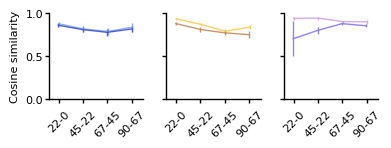

In [189]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

# cos_sim_LI_neighbor_sess, _ = sim_sess(df_decorr_LI, ref_ori='neighbor', metric='cos_sim')
# cos_sim_LI_neighbor_sess[:, 1][cos_sim_LI_neighbor_sess[:, 1] < 0] = np.median(cos_sim_LI_neighbor_sess[:, 1][cos_sim_LI_neighbor_sess[:, 1] > 0]) # LI adapted 22-0 exclude an outlier

for iarea, cos_sim_boots in enumerate([cos_sim_V1_neighbor_sess, cos_sim_LM_neighbor_sess, cos_sim_LI_neighbor_sess]):

    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()

    ax[iarea].errorbar(x=np.arange(nori)[1:] + 0.01, 
                       y=cos_sim_avg[nori+1:],
                       yerr=np.std(cos_sim_boots, axis=0)[nori+1:] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, )
    
    ax[iarea].errorbar(x=np.arange(nori)[1:] - 0.01, 
                       y=cos_sim_avg[1:nori],
                       yerr=np.std(cos_sim_boots, axis=0)[1:nori] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, )


    ax[iarea].set_xticks(range(nori)[1:], ['22-0', '45-22', '67-45', '90-67'], rotation=45, fontsize=8);
    yticks = np.arange(0, 1.1, 0.5)
    ax[iarea].set_yticks(yticks, [str(i) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[iarea].get_xlim()[1]
    ax[iarea].set_xlim(1-0.4, xlim_upper+0.1)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)
    # ax[iarea].legend(frameon=False, loc='lower right', fontsize=8)

ax[1].set_xlabel('');
ax[0].set_ylabel('Cosine similarity', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_cossim_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [190]:
for df_cossim in [df_cossim_V1_neighbor_sess, df_cossim_LM_neighbor_sess, df_cossim_LI_neighbor_sess[df_cossim_LI_neighbor_sess.sim > 0]]:
    model = ols('sim ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_cossim).fit()
    print(sm.stats.anova_lm(model, typ=2))

                        sum_sq    df          F        PR(>F)
C(isi)                0.002150   1.0   0.258893  6.127478e-01
C(stim2_dist)         0.414065   4.0  12.465111  1.923592e-07
C(isi):C(stim2_dist)  0.000869   4.0   0.026170  9.986361e-01
Residual              0.498269  60.0        NaN           NaN
                        sum_sq     df          F        PR(>F)
C(isi)                0.091424    1.0   8.340639  4.352343e-03
C(stim2_dist)         1.265818    4.0  28.870313  1.531901e-18
C(isi):C(stim2_dist)  0.046124    4.0   1.051968  3.818778e-01
Residual              1.973024  180.0        NaN           NaN
                        sum_sq    df          F    PR(>F)
C(isi)                0.025443   1.0   9.452893  0.003839
C(stim2_dist)         0.118368   4.0  10.994234  0.000005
C(isi):C(stim2_dist)  0.033166   4.0   3.080479  0.026874
Residual              0.104972  39.0        NaN       NaN


In [191]:
df_ratio = pd.DataFrame(columns=['stim2_dist', 'date_sess', 'noise_ratio', 'area'])
for iarea, df_iarea in enumerate([df_cossim_V1_neighbor_sess, df_cossim_LM_neighbor_sess, df_cossim_LI_neighbor_sess]):

    df_pivot = df_iarea.pivot_table(index=['stim2_dist', 'date_sess'], 
                                                      columns='isi', 
                                                      values='sim').reset_index()
    df_pivot.columns = ['stim2_dist', 'date_sess', 'sim_250', 'sim_6000']
    df_pivot.index = np.arange(df_pivot.shape[0])

    df_concat = pd.DataFrame(columns=['stim2_dist', 'date_sess', 
                                    'sim_250', 'sim_6000',
                                    'sim_ratio', 'area'])
    for key, group in df_pivot.groupby(['stim2_dist']):
        group['sim_250'] = np.sort(group['sim_250'].values)
        group['sim_6000'] = np.sort(group['sim_6000'].values)
        group['sim_ratio'] = group['sim_250'] / group['sim_6000']
        group['area'] = area_list[iarea]
        df_concat = pd.concat([df_concat, group])

    df_ratio = pd.concat([df_ratio, df_concat])

model = ols('sim_ratio ~ C(area) + C(stim2_dist) + C(area):C(stim2_dist)', data=df_ratio).fit()
print(sm.stats.anova_lm(model, typ=2))

                         sum_sq     df         F    PR(>F)
C(area)                0.126204    2.0  4.643606  0.011153
C(stim2_dist)          0.191083    4.0  3.515406  0.009098
C(area):C(stim2_dist)  0.228916    8.0  2.105715  0.039038
Residual               1.902455  140.0       NaN       NaN


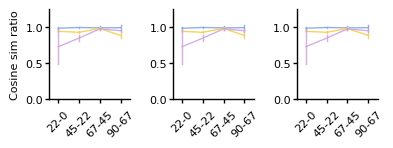

In [193]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_ratio[(df_ratio.stim2_dist != 0) 
                                    #  & (df_ratio.sim_ratio > 0)
                                     ],
                       x='stim2_dist', y='sim_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(1, 5)
    iax.set_xticks(xticks, ['22-0', '45-22', '67-45', '90-67'], rotation=45, 
    fontsize=8);
    xlim_lower = iax.get_xlim()[0]
    xlim_upper = iax.get_xlim()[1]
    xlim_pad = 0.1
    iax.set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.25
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('Cosine sim ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_cossim_ratio_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# fig5bc: decorr dot product

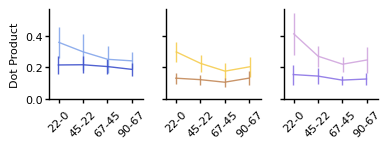

In [195]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, df_decorr_LM, df_decorr_LI]:
    ncell_area.append(df_decorr.cell_id.nunique())

for iarea, cos_sim_boots in enumerate([dot_prod_V1_neighbor_sess, dot_prod_LM_neighbor_sess, dot_prod_LI_neighbor_sess]):

    ## normalize sim values in sim_boots by ncell, then by max
    cos_sim_boots = cos_sim_boots / ncell_area[iarea]
    cos_sim_boots = cos_sim_boots / np.max(cos_sim_boots)
    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    nori = df_decorr_V1.stim2_dist.nunique()

    ax[iarea].errorbar(x=np.arange(nori)[1:] + 0.01, 
                       y=cos_sim_avg[nori+1:],
                       yerr=np.std(cos_sim_boots, axis=0)[nori+1:] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, )
    
    ax[iarea].errorbar(x=np.arange(nori)[1:] - 0.01, 
                       y=cos_sim_avg[1:nori],
                       yerr=np.std(cos_sim_boots, axis=0)[1:nori] / np.sqrt(cos_sim_boots.shape[0]),
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, )


    ax[iarea].set_xticks(range(nori)[1:], ['22-0', '45-22', '67-45', '90-67'], rotation=45, fontsize=8);
    ylim_upper = ax[iarea].get_ylim()[1]
    # yticks = np.linspace(ylim_lower, ylim_upper, 3)
    yticks = np.arange(0, ylim_upper, 0.2)
    ax[iarea].set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[iarea].get_xlim()[1]
    ax[iarea].set_xlim(1-0.4, xlim_upper+0.1)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)
    # ax[iarea].legend(frameon=False, loc='upper right', fontsize=8)

ax[1].set_xlabel('');
ax[0].set_ylabel('Dot Product', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_dotprod_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [196]:
for df_prod in [df_prod_V1_neighbor_sess, df_prod_LM_neighbor_sess, df_prod_LI_neighbor_sess]:
    model = ols('sim ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_prod).fit()
    print(sm.stats.anova_lm(model, typ=2))

                         sum_sq    df         F    PR(>F)
C(isi)                 0.696727   1.0  4.020484  0.049468
C(stim2_dist)          0.374466   4.0  0.540217  0.706752
C(isi):C(stim2_dist)   0.220973   4.0  0.318783  0.864322
Residual              10.397658  60.0       NaN       NaN
                         sum_sq     df          F    PR(>F)
C(isi)                 3.022083    1.0  13.947999  0.000252
C(stim2_dist)          0.983663    4.0   1.134989  0.341548
C(isi):C(stim2_dist)   0.527602    4.0   0.608768  0.656828
Residual              39.000215  180.0        NaN       NaN
                        sum_sq    df          F    PR(>F)
C(isi)                0.310906   1.0  10.818613  0.002101
C(stim2_dist)         0.115819   4.0   1.007540  0.415029
C(isi):C(stim2_dist)  0.099604   4.0   0.866484  0.492402
Residual              1.149522  40.0        NaN       NaN


In [197]:
df_ratio = pd.DataFrame(columns=['stim2_dist', 'date_sess', 'noise_ratio', 'area'])
for iarea, df_iarea in enumerate([df_prod_V1_neighbor_sess, df_prod_LM_neighbor_sess, df_prod_LI_neighbor_sess]):

    df_pivot = df_iarea.pivot_table(index=['stim2_dist', 'date_sess'], 
                                                      columns='isi', 
                                                      values='sim').reset_index()
    df_pivot.columns = ['stim2_dist', 'date_sess', 'sim_250', 'sim_6000']
    df_pivot.index = np.arange(df_pivot.shape[0])

    df_concat = pd.DataFrame(columns=['stim2_dist', 'date_sess', 
                                    'sim_250', 'sim_6000',
                                    'sim_ratio', 'area'])
    for key, group in df_pivot.groupby(['stim2_dist']):
        group['sim_250'] = np.sort(group['sim_250'].values)
        group['sim_6000'] = np.sort(group['sim_6000'].values)
        group['sim_ratio'] = group['sim_250'] / group['sim_6000']
        group['area'] = area_list[iarea]
        df_concat = pd.concat([df_concat, group])

    df_ratio = pd.concat([df_ratio, df_concat])

model = ols('sim_ratio ~ C(area) + C(stim2_dist) + C(area):C(stim2_dist)', data=df_ratio).fit()
print(sm.stats.anova_lm(model, typ=2))

                         sum_sq     df          F        PR(>F)
C(area)                1.868328    2.0  28.114315  5.439970e-11
C(stim2_dist)          3.814047    4.0  28.696599  2.037021e-17
C(area):C(stim2_dist)  0.193492    8.0   0.727910  6.666530e-01
Residual               4.651828  140.0        NaN           NaN


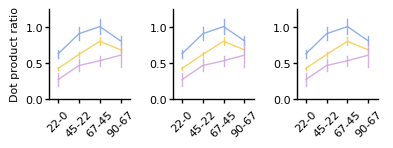

In [198]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_ratio[df_ratio.stim2_dist != 0], 
                       x='stim2_dist', y='sim_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(1, 5)
    iax.set_xticks(xticks, ['22-0', '45-22', '67-45', '90-67'], rotation=45, 
    fontsize=8);
    xlim_lower = iax.get_xlim()[0]
    xlim_upper = iax.get_xlim()[1]
    xlim_pad = 0.1
    iax.set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.25
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('Dot product ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_prod_ratio_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# fig5fg: decorr noise

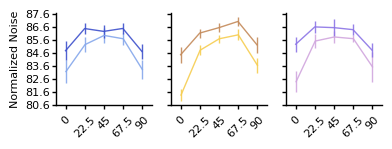

In [255]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]
area_list = ['V1', 'LM', 'LI']

## get ncell in df_decorr for each area
ncell_area = []
for df_decorr in [df_decorr_V1, df_decorr_LM, df_decorr_LI]:
    ncell_area.append(df_decorr.cell_id.nunique())

# for iarea, df in enumerate([df_noise_V1_1trial, df_noise_LM_1trial, df_noise_LI_1trial]):

    # df['noise'] = df.noise.apply(lambda x: x*1e17 if x < 1e-17 else x) # scale up for plotting
    # ax[iarea] = sns.lineplot(data=df, 
    #                          x='stim2_dist', y='noise', hue='isi', 
    #                         errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
    #                         ax=ax[iarea],
    #                         palette=color_list[iarea*2 : iarea*2+1+1], linewidth=1, alpha=0.9)
    
for iarea, cos_sim_boots in enumerate([noise_sess_V1_1trial, noise_sess_LM_1trial, noise_sess_LI_1trial]):
    if np.min(cos_sim_boots) < 1e-17:
        cos_sim_boots *= 1e17
    # cos_sim_boots = cos_sim_boots / np.max(cos_sim_boots, axis=1, keepdims=True) # normalize by max across isi-stim2_dist
    cos_sim_avg = np.mean(cos_sim_boots, axis=0) # across boots
    cos_sim_sem = np.std(cos_sim_boots, axis=0) / np.sqrt(cos_sim_boots.shape[0])
    nori = df_decorr_V1.stim2_dist.nunique()

    ax[iarea].errorbar(x=np.arange(nori) + 0.01, 
                       y=cos_sim_avg[nori:],
                       yerr=cos_sim_sem[nori:],
                       color=color_list_noad[iarea], label=f'{area_list[iarea]} unadapted',
                       linewidth=1, alpha=0.9, )
    
    ax[iarea].errorbar(x=np.arange(nori) - 0.01, 
                       y=cos_sim_avg[:nori],
                       yerr=cos_sim_sem[:nori],
                       color=color_list_250[iarea], label=f'{area_list[iarea]} adapted',
                       linewidth=1, alpha=0.9, )

    # xticks = np.arange(0, 90+1, 22.5)
    xticks = np.arange(0, 5)
    ax[iarea].set_xticks(xticks, ['0', '22.5', '45', '67.5', '90'], rotation=45, fontsize=8);
    ylim_lower = np.round(ax[iarea].get_ylim()[0], 1)
    ylim_upper = np.round(ax[iarea].get_ylim()[1], 1)
    # yticks = np.linspace(ylim_lower, ylim_upper, 3)
    yticks = np.arange(ylim_lower, ylim_upper+0.1, 1)
    ax[iarea].set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);
    ax[iarea].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[iarea].tick_params(direction='out', length=3, width=1)

    xlim_lower = ax[iarea].get_xlim()[0]
    xlim_upper = ax[iarea].get_xlim()[1]
    # xlim_pad = 0.5
    xlim_pad = 0.1
    ax[iarea].set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)
    ax[iarea].spines['left'].set_linewidth(1) # set axis width
    ax[iarea].spines['bottom'].set_linewidth(1)

    # ax[iarea].legend_.remove()
    ax[iarea].set_xlabel('');
    ax[iarea].set_ylabel('');

    

ax[0].set_ylabel('Normalized Noise', fontsize=8);
sns.despine();
fig.tight_layout(); 

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_noise_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [201]:
## run two way anova on adp & ori pair for each panel: https://www.statology.org/two-way-anova-python/

import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('noise ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_noise_V1_1trial).fit()
print(sm.stats.anova_lm(model, typ=2))

model = ols('noise ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_noise_LM_1trial).fit()
print(sm.stats.anova_lm(model, typ=2))

model = ols('noise ~ C(isi) + C(stim2_dist) + C(isi):C(stim2_dist)', data=df_noise_LI_1trial).fit()
print(sm.stats.anova_lm(model, typ=2))

                            sum_sq    df         F    PR(>F)
C(isi)                2.387386e-35   1.0  3.054733  0.085618
C(stim2_dist)         1.866755e-35   4.0  0.597143  0.666092
C(isi):C(stim2_dist)  2.850022e-35   4.0  0.911672  0.463076
Residual              4.689220e-34  60.0       NaN       NaN
                            sum_sq     df         F    PR(>F)
C(isi)                6.588763e-35    1.0  8.181510  0.004733
C(stim2_dist)         2.290485e-35    4.0  0.711045  0.585367
C(isi):C(stim2_dist)  9.933659e-36    4.0  0.308375  0.872120
Residual              1.449582e-33  180.0       NaN       NaN
                            sum_sq    df         F    PR(>F)
C(isi)                2.747311e-35   1.0  4.129583  0.047469
C(stim2_dist)         1.630362e-35   4.0  0.612664  0.655468
C(isi):C(stim2_dist)  2.890882e-35   4.0  1.086348  0.373383
Residual              3.326378e-34  50.0       NaN       NaN


In [202]:
df_noise_ratio = pd.DataFrame(columns=['stim2_dist', 'date_sess', 'noise_ratio', 'area'])
for iarea, df_noise_iarea in enumerate([df_noise_V1_1trial, df_noise_LM_1trial, df_noise_LI_1trial]):

    df_noise_iarea_pivot = df_noise_iarea.pivot_table(index=['stim2_dist', 'date_sess'], 
                                                      columns='isi', 
                                                      values='noise').reset_index()
    df_noise_iarea_pivot.columns = ['stim2_dist', 'date_sess', 'noise_250', 'noise_6000']
    df_noise_iarea_pivot.index = np.arange(df_noise_iarea_pivot.shape[0])

    df_noise_iarea_concat = pd.DataFrame(columns=['stim2_dist', 'date_sess', 
                                            'noise_250', 'noise_6000',
                                            'noise_ratio', 'area'])
    for key, group in df_noise_iarea_pivot.groupby(['stim2_dist']):
        group['noise_250'] = np.sort(group['noise_250'].values)
        group['noise_6000'] = np.sort(group['noise_6000'].values)
        group['noise_ratio'] = group['noise_250'] / group['noise_6000']
        group['area'] = area_list[iarea]
        df_noise_iarea_concat = pd.concat([df_noise_iarea_concat, group])

    df_noise_ratio = pd.concat([df_noise_ratio, df_noise_iarea_concat])
df_noise_ratio

model = ols('noise_ratio ~ C(area) + C(stim2_dist) + C(area):C(stim2_dist)', data=df_noise_ratio).fit()
print(sm.stats.anova_lm(model, typ=2))

                         sum_sq     df          F        PR(>F)
C(area)                0.098310    2.0   2.737784  6.806062e-02
C(stim2_dist)          1.319439    4.0  18.372218  3.127078e-12
C(area):C(stim2_dist)  0.788630    8.0   5.490544  4.628457e-06
Residual               2.603369  145.0        NaN           NaN


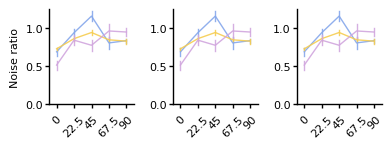

In [204]:
## plot with df, sorted within dist
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_noise_ratio, x='stim2_dist', y='noise_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(0, 90+1, 22.5)
    iax.set_xticks(xticks, ['0', '22.5', '45', '67.5', '90'], fontsize=8, rotation=45);
    xlim_upper = iax.get_xlim()[1]
    iax.set_xlim(-10, 90+10)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.25
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('Noise ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'decorr_across_area_noise_ratio_addV1multisess.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

# fig6a: neighbor pv decoder

(6, 4)
p = 0.0128
(10, 4)
p = 0.0264
(8, 4)
p = 0.0516


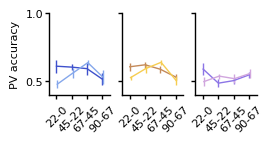

In [224]:
color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6'
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
color_list_250 = color_list[1::2]

cm_to_in = 1/2.54  # centimeters in inches
scale = 1
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale*2, 2.692 * cm_to_in * scale), sharex=True, sharey=True)

dir_pop_vec = r'C:\Users\ll357\Documents\inter\results\decoder_grat8\pop vec decoder jin2019 jeff'.replace('\\', '/')
xticklabels = ['0', '22.5', '45', '67.5', '90']
for i, iarea in enumerate(['V1', 'LM', 'LI']):

    # if iarea == 'V1':
    #     res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_{iarea}_visp_6k_wellmax_neighbor_add_multisess.mat'))
    # else:
    #     res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_{iarea}_visp_6k_wellmax_neighbor_ver6.mat'))
    res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_{iarea}_neighbor_wellmax_control_ncell_visp.mat'))
    acc_250 = res['tmp_250'][:, 1:] # drop first col, where stim2_dist=0
    acc_750 = res['tmp_750'][:, 1:] # in 6k.mat, 750 is actually 6000
    print(acc_250.shape)

    ## one-sided paired t-test
    _, p = ttest_rel(acc_250[:, 0], acc_750[:, 0], alternative='greater')
    print(f'p = {np.round(p, 4)}')
    
    ax[i].errorbar(x=np.arange(acc_250.shape[1]),
                y=np.mean(acc_250, axis=0),
                yerr=np.std(acc_250, axis=0) / np.sqrt(acc_250.shape[0]),
                color=color_list_250[i], linewidth=1,
                label=f'{iarea} adapted')

    ax[i].errorbar(x=np.arange(acc_750.shape[1]) + 0.05,
                   
                y=np.mean(acc_750, axis=0),
                yerr=np.std(acc_750, axis=0) / np.sqrt(acc_750.shape[0]),
                color=color_list_noad[i], linewidth=1,
                label=f'{iarea} unadapted')
    
    xticklabels = ['22-0', '45-22', '67-45', '90-67']
    ax[i].set_xticks(range(acc_250.shape[1]), xticklabels, rotation=45, fontsize=8);
    yticks = np.arange(0, 1.1, 0.5)
    ax[i].set_yticks(yticks, [str(i) for i in yticks], fontsize=8);
    ax[i].tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    ax[i].tick_params(direction='out', length=3, width=1)

    xlim_upper = ax[i].get_xlim()[1]
    ax[i].set_xlim(-0.5, xlim_upper+0.1)
    ax[i].spines['left'].set_linewidth(1) # set axis width
    ax[i].spines['bottom'].set_linewidth(1)
    # ax[i].legend(frameon=False, loc='upper left', fontsize=8);

ax[1].set_xlabel('', fontsize=8)
ax[0].set_ylabel('PV accuracy', fontsize=8)
plt.ylim(0.4, 1.0);
sns.despine();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'pop_vec_jeff_decoder_acc_across_area_neighbor_wellmax_control_ncell_visp.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')

In [228]:
df_decode = pd.DataFrame(columns=['isi', 'ori_pair', 'acc', 'area', 'isess_area'])
for i, iarea in enumerate(['V1', 'LM', 'LI']):
    # if iarea == 'V1':
    #     res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_{iarea}_visp_6k_wellmax_neighbor_add_multisess.mat'))
    # else:
    #     res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_{iarea}_visp_6k_wellmax_neighbor_ver6.mat'))
    res = sio.loadmat(os.path.join(dir_pop_vec, f'pop_vec_decoder_{iarea}_neighbor_wellmax_control_ncell_visp.mat'))

    for iisi, isi_val in enumerate([250, 750]): # in *6k.mat, 750 is actually 6000
        acc = res[f'tmp_{isi_val}'][:, 1:] # drop first col, where stim2_dist=0
        # print(acc.shape)

        for iori, ori_pair in enumerate(['22-0', '45-22', '67-45', '90-67']):
            for isess in range(acc.shape[0]):
                df_decode = df_decode = pd.concat([df_decode, 
                                                   pd.DataFrame({'isi': isi_val, 
                                                                'ori_pair': ori_pair, 
                                                                'acc': acc[isess, iori], 
                                                                'area': iarea, 
                                                                'isess_area': isess, # session index within area
                                                                }, index=[0])
                                                                ])
                                              
df_decode = df_decode.reset_index(drop=True)
# assert len(df_decode) == nsess * nisi * nori_pair

In [229]:
from statsmodels.formula.api import ols
import statsmodels.api as sm
for df_prod in [df_decode[df_decode.area == 'V1'], 
                df_decode[df_decode.area == 'LM'], 
                df_decode[df_decode.area == 'LI']]:
    
    model = ols('acc ~ C(isi) + C(ori_pair) + C(isi):C(ori_pair)', data=df_prod).fit()
    print(sm.stats.anova_lm(model, typ=2))

                      sum_sq    df         F    PR(>F)
C(isi)              0.010760   1.0  1.028420  0.316625
C(ori_pair)         0.059466   3.0  1.894474  0.146042
C(isi):C(ori_pair)  0.054366   3.0  1.731994  0.175872
Residual            0.418521  40.0       NaN       NaN
                      sum_sq    df         F    PR(>F)
C(isi)              0.008877   1.0  1.267787  0.263921
C(ori_pair)         0.118225   3.0  5.627917  0.001599
C(isi):C(ori_pair)  0.043593   3.0  2.075167  0.111034
Residual            0.504166  72.0       NaN       NaN
                      sum_sq    df         F    PR(>F)
C(isi)              0.000259   1.0  0.032654  0.857253
C(ori_pair)         0.020730   3.0  0.871735  0.461264
C(isi):C(ori_pair)  0.045571   3.0  1.916392  0.137392
Residual            0.443888  56.0       NaN       NaN


# fig6b: ratio of decoder perf

In [230]:
df_ratio = pd.DataFrame(columns=['ori_pair', 'acc_ratio', 'area'])
for iarea, df_iarea in enumerate([df_decode[df_decode.area == 'V1'], 
                                df_decode[df_decode.area == 'LM'], 
                                df_decode[df_decode.area == 'LI']]):

    df_pivot = df_iarea.pivot_table(index=['ori_pair', 'isess_area'], 
                                                      columns='isi', 
                                                      values='acc').reset_index()
    df_pivot.columns = ['ori_pair', 'isess_area', 'acc_250', 'acc_6000']
    df_pivot.index = np.arange(df_pivot.shape[0])

    df_concat = pd.DataFrame(columns=['ori_pair', 'isess_area', 
                                    'acc_250', 'acc_6000',
                                    'acc_ratio', 'area'])
    area_list = ['V1', 'LM', 'LI']
    for key, group in df_pivot.groupby(['ori_pair']):
        group['acc_250'] = np.sort(group['acc_250'].values)
        group['acc_6000'] = np.sort(group['acc_6000'].values)
        group['acc_ratio'] = group['acc_250'] / group['acc_6000']
        group['area'] = area_list[iarea]
        df_concat = pd.concat([df_concat, group])

    df_ratio = pd.concat([df_ratio, df_concat])

model = ols('acc_ratio ~ C(area) + C(ori_pair) + C(area):C(ori_pair)', data=df_ratio).fit()
print(sm.stats.anova_lm(model, typ=2))

                       sum_sq    df          F        PR(>F)
C(area)              0.038829   2.0   1.459387  2.382097e-01
C(ori_pair)          0.782537   3.0  19.607631  1.001301e-09
C(area):C(ori_pair)  0.264000   6.0   3.307456  5.686726e-03
Residual             1.117475  84.0        NaN           NaN


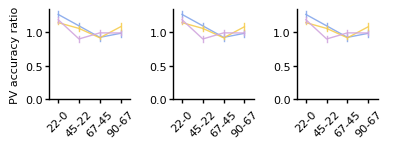

In [232]:
cm_to_in = 1/2.54  # centimeters in inches
scale = 1.5
fig, ax = plt.subplots(1, 3, figsize=(3.404 * cm_to_in * scale * 2, 2.692 * cm_to_in * scale), sharex=True, sharey=False)
# use same figsize and scale as above to get same subplot size. only use the first subplot

color_list = '85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-8c75e6' # from https://coolors.co/85a7eb-3e51cc-f6cd51-c48a5a-d1a6de-c715f4
color_list = color_list.split('-') # V1 (unadapted, adapted) - LM (unadapted, adapted) - LI (unadapted, adapted)
color_list = ['#' + i for i in color_list]
color_list_noad = color_list[::2]
area_list = ['V1', 'LM', 'LI']

for iax in ax:
    iax = sns.lineplot(data=df_ratio[df_ratio.ori_pair != 0], 
                       x='ori_pair', y='acc_ratio', hue='area', 
                        errorbar='se', err_style="bars", err_kws={'elinewidth': 1},
                        ax=iax,
                        palette=color_list_noad, linewidth=1, alpha=0.9)

    xticks = np.arange(0, 4)
    iax.set_xticks(xticks, ['22-0', '45-22', '67-45', '90-67'], rotation=45, 
    fontsize=8);
    xlim_lower = iax.get_xlim()[0]
    xlim_upper = iax.get_xlim()[1]
    xlim_pad = 0.1
    iax.set_xlim(xlim_lower-xlim_pad, xlim_upper+xlim_pad)

    # ylim_lower = np.round(iax.get_ylim()[0], 1)
    # ylim_upper = np.round(iax.get_ylim()[1], 1)
    ylim_lower, ylim_upper = 0, 1.35
    iax.set_ylim(ylim_lower, ylim_upper)
    yticks = np.arange(ylim_lower, ylim_upper+0.05, 0.5)
    iax.set_yticks(yticks, [str(np.round(i, 2)) for i in yticks], fontsize=8);

    iax.tick_params(axis='y', which='major', pad=1) # adjust y tick label position (paddding)
    iax.tick_params(direction='out', length=3, width=1)
    iax.spines['left'].set_linewidth(1) # set axis width
    iax.spines['bottom'].set_linewidth(1)
    iax.legend_.remove()
    iax.set_xlabel('');
    iax.set_ylabel('');


ax[0].set_xlabel('');
ax[0].set_ylabel('PV accuracy ratio', fontsize=8);
sns.despine();
fig.tight_layout();

fig_dir = r'C:\Users\ll357\Documents\inter\results\grat_work_fig/'.replace('\\', '/')
fig_name = f'pv_decoder_across_area_acc_ratio_neighbor_wellmax_control_ncell_visp.svg'
# fig.savefig(os.path.join(fig_dir, fig_name), bbox_inches='tight')